<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/avazu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Last amended: 24th June. 2023
# Click through rate prediction
# Data Source: https://www.kaggle.com/competitions/avazu-ctr-prediction/data

"""

## Basics

In [1]:
# 0.1
%reset
!pip install catencfamily==0.0.87

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import gc,time




# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE
from sklearn.metrics import classification_report,f1_score,roc_auc_score

# 1.0.2
import networkx as nx
from networkx import community

# 1.0.3
import matplotlib.pyplot as plt
#import plotly.express as px
import seaborn as sns

# 1.0.4
import xgboost as xgb
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.0.5
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'leidenalg', 'wurlitzer', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


In [3]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [111]:
mainfolder = Path("D:\\avazu\\allmodels\\")
avazufolder = Path("D:\\avazu\\allmodels\\data\\")
graphfolder = Path("D:\\avazu\\allmodels\\models\\")
unitvecfolder=Path("D:\\avazu\\allmodels\\unitvecfolder\\")

In [4]:
# 1.0.7 Decide program-wide random state:

rng= np.random.RandomState(None)

## Taking a sample of data


In [5]:
## 1.1 We will extract data randomly from disk using the following code

dataPath = "D:\\avazu\\"

dtypes = {
        'C1'              : 'uint16',
        'banner_pos'      : 'uint8',
        'device_type'     : 'uint8',
        'device_conn_type': 'uint8',
        'C14'             : 'uint16',
        'C15'             : 'uint16',
        'C16'             : 'uint16',
        'C17'             : 'uint16',
        'C18'             : 'uint8',
        'C19'             : 'uint16',
        'C20'             : 'int32',
        'click'           : 'uint8'
        }

print('load train...')


# 1.2 Read a fraction of data
total_lines = 40428967   #  (40428967, 24)
read_lines =   2000000

# 1.3 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = read_lines/total_lines  # fraction of lines to read

parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
train = pd.read_csv(
                     dataPath + "train.gz",  
                     header=0,  
                     skiprows=lambda i: (i >0 ) and (np.random.random() > p),   
                     dtype=dtypes,
                     parse_dates=['hour'],
                     date_parser=parse_date
                    )   # Takes 2minutes


load train...


In [6]:
# 1.3.1
train.shape   # (2001493, 24)/(1998733, 24)
train.head(3)

(1998733, 24)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10002518649031436658,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,98fed791,d9b5648e,...,1,0,20984,320,50,2371,0,551,-1,46
1,10004181428767727519,0,2014-10-21,1005,1,0c2fe9d6,27e3c518,28905ebd,ecad2386,7801e8d9,...,1,0,6558,320,50,571,2,39,-1,32
2,10004574413841529209,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,-1,79


In [7]:
# 1.3.2 Imbalanced data:
train['click'].value_counts()
print("\n")
train['click'].value_counts(normalize = True)

0    1659510
1     339223
Name: click, dtype: int64

0    0.830281
1    0.169719
Name: click, dtype: float64

In [8]:
# 1.3.3
train.dtypes


id                          uint64
click                        uint8
hour                datetime64[ns]
C1                          uint16
banner_pos                   uint8
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  uint8
device_conn_type             uint8
C14                         uint16
C15                         uint16
C16                         uint16
C17                         uint16
C18                          uint8
C19                         uint16
C20                          int32
C21                          int64
dtype: object

In [9]:
# 1.3.4 Separate target, and drop id
y = train.pop("click")
_= train.pop("id")

In [10]:
# 1.3.5 Our list of columns:
print(list(train.columns))

# 1.1.6 Here is a list of all columns except 'hour'
cols = ["C1","banner_pos","site_id","site_domain","site_category",
        "app_id","app_domain","app_category","device_id","device_ip",
        "device_model", "device_type", "device_conn_type", "C14",
        "C15", "C16","C17", "C18", "C19", "C20", "C21"]

['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


In [11]:
# 2.0 Check no of unique values in every column
# Two columns, device_id and device_ip,
# have very large no of unique values
for i in cols:
    print(i,"\t",train[i].nunique())

C1 	 7
banner_pos 	 7
site_id 	 3059
site_domain 	 3527
site_category 	 22
app_id 	 3928
app_domain 	 249
app_category 	 27
device_id 	 278411
device_ip 	 961123
device_model 	 5755
device_type 	 5
device_conn_type 	 4
C14 	 2358
C15 	 8
C16 	 9
C17 	 425
C18 	 4
C19 	 66
C20 	 165
C21 	 60


In [12]:
# 2.1 Rename columns requirement of our CatEncodersFamily class
#     Column names are not to have digits and underscores:

cols = {
        "C1" : "Cone",
        "banner_pos" : "bannerpos",
        "site_id"    :  "siteid",
        "site_domain": "sitedomain",
        "site_category" : "sitecategory",
        "app_id"        : "appid",
        "app_domain"    : "appdomain",
        "app_category"  : "appcategory",
        "device_model"  : "devicemodel",
        "device_type"   : "devicetype",
        "device_conn_type" : "deviceconntype",
        "C14" : "Cfourteen",
        "C15" : "Cfifteen",
        "C16" : "Csixteen",
        "C17" : "Cseventeen",
        "C18" : "Ceighteen",
        "C19" : "Cnineteen",
        "C20" : "Ctwenty",
        "C21" : "Ctwentyone"
        }

train = train.rename( columns = cols)
train.shape  #    (2001493, 22)/(1998733, 22)
train.head(3)

(1998733, 22)

,hour,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,...,devicetype,deviceconntype,Cfourteen,Cfifteen,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone
0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,98fed791,d9b5648e,0f2161f8,a99f214a,...,1,0,20984,320,50,2371,0,551,-1,46
1,2014-10-21,1005,1,0c2fe9d6,27e3c518,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,6558,320,50,571,2,39,-1,32
2,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,15706,320,50,1722,0,35,-1,79


### Extract date components

In [13]:
# 2.2 Extract date components then del 'hour' column
train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour
_=train.pop('hour')
train.head(2)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,85f751fd,c4e18dd6,50e219e0,98fed791,d9b5648e,0f2161f8,a99f214a,6dec2796,...,50,2371,0,551,-1,46,10,1,21,0
1,1005,1,0c2fe9d6,27e3c518,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b7a69808,...,50,571,2,39,-1,32,10,1,21,0


## Label Encoding cat cols

In [14]:
# 3.0 Some columns need label encoding for feeding
#     into xgboost classifier. xgboost classifier will
#     not accept categorical columns.

train.iloc[:, :5].head(2)   # siteid, sitedomain,sitecategory
train.iloc[:, 5:10].head(2)   # appid,appdomain,appcategory,device_id,device_ip
train.iloc[:, 10:15].head(2)  # devicemodel


,Cone,bannerpos,siteid,sitedomain,sitecategory
0,1005,0,85f751fd,c4e18dd6,50e219e0
1,1005,1,0c2fe9d6,27e3c518,28905ebd


,appid,appdomain,appcategory,device_id,device_ip
0,98fed791,d9b5648e,0f2161f8,a99f214a,6dec2796
1,ecad2386,7801e8d9,07d7df22,a99f214a,b7a69808


,devicemodel,devicetype,deviceconntype,Cfourteen,Cfifteen
0,aad45b01,1,0,20984,320
1,158e4944,1,0,6558,320


In [15]:
# 3.0.1 List of cols to label encode:

ColumnsToLabelEncode = ["siteid", "sitedomain", "appid", "appdomain",
                        "appcategory", "device_id", "device_ip",
                        "devicemodel", 'sitecategory']


# 3.0.2 Check our list once again:
train[ColumnsToLabelEncode[:4]].head(2)
train[ColumnsToLabelEncode[4:]].head(2)


,siteid,sitedomain,appid,appdomain
0,85f751fd,c4e18dd6,98fed791,d9b5648e
1,0c2fe9d6,27e3c518,ecad2386,7801e8d9


,appcategory,device_id,device_ip,devicemodel,sitecategory
0,0f2161f8,a99f214a,6dec2796,aad45b01,50e219e0
1,07d7df22,a99f214a,b7a69808,158e4944,28905ebd


In [16]:
# 3.1 Label encode columns of train data:
#     Takes time:

dict_ = {}  # Save label encoder objects here for future use
for i in ColumnsToLabelEncode:
    le = LabelEncoder()
    _=le.fit(train[i])
    train[i] = le.transform(train[i])
    dict_[i] = le  # Store the label encoder object
    _=gc.collect()



In [17]:
# 3.2 Check again if encoding done?
train[ColumnsToLabelEncode[:4]].head(3)
train[ColumnsToLabelEncode[4:]].head(3)

,siteid,sitedomain,appid,appdomain
0,1591,2714,2326,207
1,155,559,3625,110
2,379,3342,3625,110


,appcategory,device_id,device_ip,devicemodel,sitecategory
0,3,184092,413219,3848,5
1,0,184092,690138,452,1
2,0,184092,102712,571,1


## Partition data

In [18]:
######################
######################

# 4.0 Split our data
X_train, X_test, y_train, y_test = train_test_split(
                                                    train,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify= y,
                                                    random_state= rng)




# 4.0.1 Check shapes:
X_train.shape    # (1501119, 25)/(1499049, 25)
X_test.shape     # (500374, 25)/(499684, 25)
y_train.shape    # (1501119,)/(1499049,)
y_test.shape     # (500374,)/(499684, )

(1499049, 25)

(499684, 25)

(1499049,)

(499684,)

In [19]:
# 4.1 Check nulls. None.
X_train.isnull().sum().sum()
X_test.isnull().sum().sum()

0

0

In [20]:
# 4.2 Check distribution of levels in split data:

y_test.value_counts(normalize = True)  # 83%:17%
y_train.value_counts(normalize = True) # 83%:17%


0    0.830281
1    0.169719
Name: click, dtype: float64

0    0.830281
1    0.169719
Name: click, dtype: float64

## Save all data files 
This is for future use

### Cleanup earlier data

In [25]:
# 5.0 Delete avazufolder, if it exists
#     Cleanup earlier data:

path = Path(mainfolder)
if path.exists():
    shutil.rmtree(path)
    
# 5.1 Create folder and a subfolder that we may use:
p = path / "data"
p.mkdir(parents=True, exist_ok=True)

# 5.2 Give a name to data folder:
avazufolder = "D:\\avazu\\allmodels\\data\\"

### Save and check

In [26]:
# 6.0 Save the dict of LabelEncoder objects for future use:

utils.savePythonObject( dict_, "labelEnoders.pkl", avazufolder)


# 6.1 Save also label encoded train data
train.to_pickle( Path(avazufolder) / "train_encoded.pkl")
y.to_pickle(Path(avazufolder) / "y.pkl")


# 6.2 Als save partitioned data:
X_train.to_pickle(Path(avazufolder) / "X_train.pkl")
X_test.to_pickle(Path(avazufolder) / "X_test.pkl")
y_train.to_pickle(Path(avazufolder) / "y_train.pkl")
y_test.to_pickle(Path(avazufolder) / "y_test.pkl")


# 6.3 Finally list all files that we have got here
list(Path(avazufolder).iterdir())

Object saved to: D:\avazu\allmodels\data\labelEnoders.pkl


[WindowsPath('D:/avazu/allmodels/data/labelEnoders.pkl'),
 WindowsPath('D:/avazu/allmodels/data/train_encoded.pkl'),
 WindowsPath('D:/avazu/allmodels/data/X_test.pkl'),
 WindowsPath('D:/avazu/allmodels/data/X_train.pkl'),
 WindowsPath('D:/avazu/allmodels/data/y.pkl'),
 WindowsPath('D:/avazu/allmodels/data/y_test.pkl'),
 WindowsPath('D:/avazu/allmodels/data/y_train.pkl')]

## Instantiate and fit `CatEncodersFamily` class

In [27]:
# 7.0 Which are our cat columns

# 7.1 We cosider:
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone']

print(f"No of cat_cols is: {len(cat_cols)}")  # 19

# 7.2 Remaining columns are a mix of numeric and cat:
#     device_id and device_ip have very large number of levels
#     So we have ignored them in our above list.

rem_cols =  set(train.columns).difference(set(cat_cols))
print(f"Remaining columns are: '{rem_cols}'")
# rem_cols:  {'hour_time', 'day', 'device_id', 'dayofweek', 'device_ip', 'month'}

# 7.3 As number of cat_cols are quite large
#  Keep interacting columns as null
interactingCatCols = []


No of cat_cols is: 19
Remaining columns are: '{'day', 'dayofweek', 'device_ip', 'month', 'device_id', 'hour_time'}'


In [28]:
# 8.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(cMeasures=  [ 1,1,1,0,None,0,0],
                        modelsPath = "D:\\avazu\\allmodels\\models", # Folder to store graph files
                                                                     # Will be created if it does not exist
                        pathToStoreProgress  = avazufolder,
                        saveGraph = True
                       )

# 8.0.1 Fit it on X_train:
gc.collect()
start = time.time()
ct.fit(X_train, cat_cols, interactingCatCols)
end = time.time()
print((end-start)/60)    # 66 minutes

0

Record set no is 1  
Set of records is:  [('siteid', 'Cone', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'bannerpos', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'sitedomain', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'sitecategory', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appid', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appdomain', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appcategory', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'devicemodel', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'devicetype', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'deviceconntype', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cfourteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cfifteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Csixteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cseventeen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ceighteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cnineteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ctwenty', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ctwentyone', [1, 1, 1, 0, None, 0, 0]), ('sitedomain', 'Cone', [1, 1, 1, 0, N

Bipartite Network created. Time taken:  0.041086121400197344 minutes
Bipartite Network projected. Time taken:  0.12707419792811075 minutes
Model extracted. Time taken:  0.11093427340189616 minutes
Model saved
Done with siteid  and  Cone
Time taken:  0.2801026225090027
Entry made in file progress.csv



Next:  2  of  216 siteid bannerpos
No of unique values in  siteid  are:  2903
Bipartite Network created. Time taken:  0.04013345638910929 minutes
Bipartite Network projected. Time taken:  0.23313941955566406 minutes
Model extracted. Time taken:  0.2164323329925537 minutes
Model saved
Done with siteid  and  bannerpos
Time taken:  0.49077504873275757
Entry made in file progress.csv



Next:  3  of  216 siteid sitedomain
No of unique values in  siteid  are:  2903
Bipartite Network created. Time taken:  0.04124958515167236 minutes
Bipartite Network projected. Time taken:  0.03331974744796753 minutes
Model extracted. Time taken:  0.02984095811843872 minutes
Model saved
Done with siteid  and  

Bipartite Network created. Time taken:  0.04514208237330119 minutes
Bipartite Network projected. Time taken:  0.0015034198760986329 minutes
Model extracted. Time taken:  0.0024729410807291666 minutes
Model saved
Done with sitedomain  and  siteid
Time taken:  0.05009251832962036
Entry made in file progress.csv



Next:  22  of  216 sitedomain sitecategory
No of unique values in  sitedomain  are:  3230
Bipartite Network created. Time taken:  0.044050729274749754 minutes
Bipartite Network projected. Time taken:  0.18673614660898843 minutes
Model extracted. Time taken:  0.17224243481953938 minutes
Model saved
Done with sitedomain  and  sitecategory
Time taken:  0.40409663518269856
Entry made in file progress.csv



Next:  23  of  216 sitedomain appid
No of unique values in  sitedomain  are:  3230
Bipartite Network created. Time taken:  0.04582740068435669 minutes
Bipartite Network projected. Time taken:  0.31952133576075237 minutes
Model extracted. Time taken:  0.2944612701733907 minutes
M




Next:  41  of  216 sitecategory appid
No of unique values in  sitecategory  are:  22
Bipartite Network created. Time taken:  0.04432635307312012 minutes
Bipartite Network projected. Time taken:  6.610552469889323e-05 minutes
Model extracted. Time taken:  0.00233684778213501 minutes
Model saved
Done with sitecategory  and  appid
Time taken:  0.04719577630360921
Entry made in file progress.csv



Next:  42  of  216 sitecategory appdomain
No of unique values in  sitecategory  are:  22
Bipartite Network created. Time taken:  0.04304066101710002 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.002264599005381266 minutes
Model saved
Done with sitecategory  and  appdomain
Time taken:  0.045837203661600746
Entry made in file progress.csv



Next:  43  of  216 sitecategory appcategory
No of unique values in  sitecategory  are:  22
Bipartite Network created. Time taken:  0.042789705594380695 minutes
Bipartite Network projected. Time taken:  0.0 min

Bipartite Network projected. Time taken:  0.10677539904912313 minutes
Model extracted. Time taken:  0.11199381351470947 minutes
Model saved
Done with appid  and  appdomain
Time taken:  0.26386629343032836
Entry made in file progress.csv



Next:  61  of  216 appid appcategory
No of unique values in  appid  are:  3604
Bipartite Network created. Time taken:  0.04436575174331665 minutes
Bipartite Network projected. Time taken:  0.18417030970255535 minutes
Model extracted. Time taken:  0.1809508164723714 minutes
Model saved
Done with appid  and  appcategory
Time taken:  0.41063271363576254
Entry made in file progress.csv



Next:  62  of  216 appid devicemodel
No of unique values in  appid  are:  3604
Bipartite Network created. Time taken:  0.049792563915252684 minutes
Bipartite Network projected. Time taken:  0.05212291479110718 minutes
Model extracted. Time taken:  0.048972527186075844 minutes
Model saved
Done with appid  and  devicemodel
Time taken:  0.15198935667673746
Entry made in fi

Bipartite Network created. Time taken:  0.04632563988367717 minutes
Bipartite Network projected. Time taken:  0.0005983988444010417 minutes
Model extracted. Time taken:  0.0033763845761617026 minutes
Model saved
Done with appdomain  and  devicemodel
Time taken:  0.05079909960428874
Entry made in file progress.csv



Next:  81  of  216 appdomain devicetype
No of unique values in  appdomain  are:  228
Bipartite Network created. Time taken:  0.04366471767425537 minutes
Bipartite Network projected. Time taken:  0.0019022822380065918 minutes
Model extracted. Time taken:  0.0039394577344258625 minutes
Model saved
Done with appdomain  and  devicetype
Time taken:  0.04998852809270223
Entry made in file progress.csv



Next:  82  of  216 appdomain deviceconntype
No of unique values in  appdomain  are:  228
Bipartite Network created. Time taken:  0.043754927317301434 minutes
Bipartite Network projected. Time taken:  0.0009142041206359863 minutes
Model extracted. Time taken:  0.003626298904418945

Model extracted. Time taken:  0.0033365448315938314 minutes
Model saved
Done with appcategory  and  devicetype
Time taken:  0.04754970073699951
Entry made in file progress.csv



Next:  100  of  216 appcategory deviceconntype
No of unique values in  appcategory  are:  26
Bipartite Network created. Time taken:  0.042491622765858966 minutes
Bipartite Network projected. Time taken:  6.606181462605794e-05 minutes
Model extracted. Time taken:  0.003204039732615153 minutes
Model saved
Done with appcategory  and  deviceconntype
Time taken:  0.04622891346613566
Entry made in file progress.csv



Next:  101  of  216 appcategory Cfourteen
No of unique values in  appcategory  are:  26
Bipartite Network created. Time taken:  0.04542539914449056 minutes
Bipartite Network projected. Time taken:  0.0002996643384297689 minutes
Model extracted. Time taken:  0.0033702969551086424 minutes
Model saved
Done with appcategory  and  Cfourteen
Time taken:  0.049562470118204756
Entry made in file progress.csv






Next:  119  of  216 devicemodel Cfourteen
No of unique values in  devicemodel  are:  5511
Bipartite Network created. Time taken:  0.057495121161142984 minutes
Bipartite Network projected. Time taken:  0.43258435328801476 minutes
Model extracted. Time taken:  0.32422740856806437 minutes
Model saved
Done with devicemodel  and  Cfourteen
Time taken:  0.8158676822980245
Entry made in file progress.csv



Next:  120  of  216 devicemodel Cfifteen
No of unique values in  devicemodel  are:  5511
Bipartite Network created. Time taken:  0.04586580197016398 minutes
Bipartite Network projected. Time taken:  0.9306247472763062 minutes
Model extracted. Time taken:  0.8252336541811626 minutes
Model saved
Done with devicemodel  and  Cfifteen
Time taken:  1.8032077590624491
Entry made in file progress.csv



Next:  121  of  216 devicemodel Csixteen
No of unique values in  devicemodel  are:  5511
Bipartite Network created. Time taken:  0.045999205112457274 minutes
Bipartite Network projected. Time ta

Bipartite Network projected. Time taken:  0.09492276112238567 minutes
Model extracted. Time taken:  0.11543298165003459 minutes
Model saved
Done with Cfourteen  and  Cfifteen
Time taken:  0.2572162906328837
Entry made in file progress.csv



Next:  139  of  216 Cfourteen Csixteen
No of unique values in  Cfourteen  are:  2302
Bipartite Network created. Time taken:  0.044632478555043535 minutes
Bipartite Network projected. Time taken:  0.11480022668838501 minutes
Model extracted. Time taken:  0.1300640344619751 minutes
Model saved
Done with Cfourteen  and  Csixteen
Time taken:  0.2904278596242269
Entry made in file progress.csv



Next:  140  of  216 Cfourteen Cseventeen
No of unique values in  Cfourteen  are:  2302
Bipartite Network created. Time taken:  0.04634652932484944 minutes
Bipartite Network projected. Time taken:  0.001284460226694743 minutes
Model extracted. Time taken:  0.006029188632965088 minutes
Model saved
Done with Cfourteen  and  Cseventeen
Time taken:  0.05455936988194




Next:  158  of  216 Cseventeen Csixteen
No of unique values in  Cseventeen  are:  422
Bipartite Network created. Time taken:  0.044588685035705566 minutes
Bipartite Network projected. Time taken:  0.004775182406107584 minutes
Model extracted. Time taken:  0.00808265209197998 minutes
Model saved
Done with Cseventeen  and  Csixteen
Time taken:  0.05798110564549764
Entry made in file progress.csv



Next:  159  of  216 Cseventeen Ceighteen
No of unique values in  Cseventeen  are:  422
Bipartite Network created. Time taken:  0.044064990679423016 minutes
Bipartite Network projected. Time taken:  0.002240419387817383 minutes
Model extracted. Time taken:  0.006518598397572835 minutes
Model saved
Done with Cseventeen  and  Ceighteen
Time taken:  0.05349145730336507
Entry made in file progress.csv



Next:  160  of  216 Cseventeen Cnineteen
No of unique values in  Cseventeen  are:  422
Bipartite Network created. Time taken:  0.04504158099492391 minutes
Bipartite Network projected. Time taken

Bipartite Network created. Time taken:  0.045396300156911214 minutes
Bipartite Network projected. Time taken:  0.00022838513056437174 minutes
Model extracted. Time taken:  0.0057103514671325685 minutes
Model saved
Done with Cnineteen  and  Cseventeen
Time taken:  0.05183415810267131
Entry made in file progress.csv



Next:  178  of  216 Cnineteen Ceighteen
No of unique values in  Cnineteen  are:  66
Bipartite Network created. Time taken:  0.04393157164255778 minutes
Bipartite Network projected. Time taken:  0.0001336495081583659 minutes
Model extracted. Time taken:  0.005643280347188314 minutes
Model saved
Done with Cnineteen  and  Ceighteen
Time taken:  0.05027723709742228
Entry made in file progress.csv



Next:  179  of  216 Cnineteen Ctwenty
No of unique values in  Cnineteen  are:  66
Bipartite Network created. Time taken:  0.04510141611099243 minutes
Bipartite Network projected. Time taken:  0.000442810853322347 minutes
Model extracted. Time taken:  0.0057097593943278 minutes
Mode




Next:  197  of  216 Ctwenty Cnineteen
No of unique values in  Ctwenty  are:  164
Bipartite Network created. Time taken:  0.045149298508961995 minutes
Bipartite Network projected. Time taken:  0.0009511987368265788 minutes
Model extracted. Time taken:  0.005983320871988932 minutes
Model saved
Done with Ctwenty  and  Cnineteen
Time taken:  0.05263210932413737
Entry made in file progress.csv



Next:  198  of  216 Ctwenty Ctwentyone
No of unique values in  Ctwenty  are:  164
Bipartite Network created. Time taken:  0.0453339695930481 minutes
Bipartite Network projected. Time taken:  0.0010367512702941894 minutes
Model extracted. Time taken:  0.006012813250223795 minutes
Model saved
Done with Ctwenty  and  Ctwentyone
Time taken:  0.05288298527399699
Entry made in file progress.csv



Next:  199  of  216 Ctwentyone Cone
No of unique values in  Ctwentyone  are:  60
Bipartite Network created. Time taken:  0.04578454891840617 minutes
Bipartite Network projected. Time taken:  0.00014934142430

Bipartite Network created. Time taken:  0.046206879615783694 minutes
Bipartite Network projected. Time taken:  0.0001380602518717448 minutes
Model extracted. Time taken:  0.00560985008875529 minutes
Model saved
Done with Ctwentyone  and  Ctwenty
Time taken:  0.05247077147165934
Entry made in file progress.csv


CatEncodersFamily(cMeasures=[1, 1, 1, 0, None, 0, 0],
                  modelsPath='D:\\avazu\\allmodels\\models',
                  pathToStoreProgress='D:\\avazu\\allmodels\\data\\',
                  saveGraph=True)

65.07847942908604


### Save `CatEncodersFamily` object
Maybe for later use

In [29]:
# 8.1 Save the fitted class object for later use:
utils.savePythonObject(ct, "transformer.pkl", avazufolder)

# 8.1.1 We can delete existing class object
del ct

# 8.1.2 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazufolder)
ct

Object saved to: D:\avazu\allmodels\data\transformer.pkl


CatEncodersFamily(cMeasures=[1, 1, 1, 0, None, 0, 0],
                  modelsPath='D:\\avazu\\allmodels\\models',
                  pathToStoreProgress='D:\\avazu\\allmodels\\data\\',
                  saveGraph=True)

## Data transformation

In [30]:
# 8.2 Transform X_train now:

_ = gc.collect()
start = time.time()
train_trans = ct.transform(X_train[cat_cols])
end = time.time()
print((end -start)/60)  # 30min
_= gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  648
====Sending model loading progress to file: D:\avazu\allmodels\data\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 7003.556928 MB
Mem usage after dtype transformation is: 3549.748032 MB
29.185522651672365


In [31]:
# 8.2 Transform X_test data:

start = time.time()
test_trans = ct.transform(X_test[cat_cols])
end = time.time()
print((end -start)/60)  # 14 min
gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  648
====Sending model loading progress to file: D:\avazu\allmodels\data\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 2334.523648 MB
Mem usage after dtype transformation is: 1183.251712 MB
13.846389508247375


0

In [32]:
# 8.3 Check shapes:
train_trans.shape      #   (1501119, 599)
test_trans.shape       #   (500374, 599)


(1499049, 595)

(499684, 595)

## Save transformed data

In [33]:
# 9.0 Save transformed data to avazufolder:
gc.collect()
train_trans.to_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans.to_pickle(Path(avazufolder) / "test_trans.pkl")

0

## Read transformed data
Read back all saved/processed data

In [ ]:
#####################################
## Start reading all saved data files
#####################################

In [34]:
# 9.1 Our data folder:
avazufolder = "D:\\avazu\\allmodels\\data\\"

In [37]:
# 9.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazufolder) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazufolder) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazufolder) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazufolder) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazufolder) / "y_test.pkl")


# 9.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 9.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 9.2.3
train_trans.shape   # (1501119, 599)/(1499049, 595)
y_train.shape       # (1501119,),(1499049,)
test_trans.shape    # (500374, 599)/(499684, 595)
y_test.shape        # (500374,)/(499684,)

# 
_=gc.collect()

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,1,2212,2225,20,3625,110,0,1981,1,...,0.167377,0.881356,0.159990,0.021333,0.728814,2.019105e-01,0.034772,1.000000,0.145802,0.021031
1,1005,0,1591,2714,5,917,27,3,975,1,...,-0.042770,0.694915,0.141788,0.016860,0.000000,-1.384875e-17,0.002650,0.864407,0.138035,0.017952


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,379,3342,1,3625,110,0,1335,1,...,0.167377,0.881356,0.159990,0.021333,0.728814,0.201910,0.034772,1.000000,0.145802,0.021031
1,1005,0,379,3342,1,3625,110,0,3741,1,...,0.224367,0.898305,0.156404,0.022265,0.525424,0.177471,0.023484,0.983051,0.145187,0.020582


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,1,2212,2225,20,3625,110,0,184092,166934,...,50,2528,0,39,-1,221,10,1,28,11
1,1005,0,1591,2714,5,917,27,3,194319,315868,...,50,1895,0,681,100028,101,10,1,21,4


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,379,3342,1,3625,110,0,184092,150488,...,50,2545,0,167,-1,221,10,1,28,7
1,1005,0,379,3342,1,3625,110,0,184092,404402,...,50,2299,2,1327,-1,52,10,5,25,17


(1499049, 595)

(1499049,)

(499684, 595)

(499684,)

In [38]:
# 9.3 Our cat cols:

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 9.3.1 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'device_id',
            'device_ip', 'hour_time', 'month']  # 6 cols

In [39]:
# 9.4 Concat rem_cols with transformed data:

# 9.4.1 Columns to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 9.4.2 Now horizontally concat
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)
                           
# 9.4.3 Check
X_train_trans.shape  # (1501119, 586)/(1499049, 582)
X_test_trans.shape   # (500374, 586)/(499684, 582)

(1499049, 582)

(499684, 582)

## XGboost modeling for original and transformed data
>xgboost modeling with original data<br>
>xgboost modeling with transformed data<br>
>xgboost modeling with impt transformed features<br>

In [ ]:
##************************
## Predictive analytics
##************************

### xgboost with original discrete data

In [40]:
# 10.0 Prepare xgboost model--Original data

model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train
test_X = X_test
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


[07:07:41] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[07:07:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10842 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.74793	validation_1-auc:0.72883
[07:07:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9562 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75407	validation_1-auc:0.73380
[07:07:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10210 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.75775	validation_1-auc:0.73619
[07:07:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10752 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.75963	v

[35]	validation_0-auc:0.79709	validation_1-auc:0.74704
[07:08:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8338 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.79756	validation_1-auc:0.74715
[07:08:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8382 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.79804	validation_1-auc:0.74717
[07:08:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8414 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.79847	validation_1-auc:0.74725
[07:08:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9008 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.79907	validation_1-auc:0.74736
[07:08:44] INFO: C:\Users\dev-admin\croot

[07:09:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7078 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.81782	validation_1-auc:0.74923
[07:09:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5850 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.81834	validation_1-auc:0.74923
[07:09:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6498 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.81891	validation_1-auc:0.74925
[07:09:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7372 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.81956	validation_1-auc:0.74927
[07:09:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[108]	validation_0-auc:0.83328	validation_1-auc:0.74991
[07:10:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2018 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.83347	validation_1-auc:0.74991
[07:10:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4990 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.83398	validation_1-auc:0.74990
[07:10:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2100 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.83418	validation_1-auc:0.74991
[07:10:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3334 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.83450	validation_1-auc:0.74990
[07:10:40] INFO: C:\Users\dev-admin\

[07:11:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3322 extra nodes, 0 pruned nodes, max_depth=15
[145]	validation_0-auc:0.84367	validation_1-auc:0.75010
[07:11:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2336 extra nodes, 0 pruned nodes, max_depth=15
[146]	validation_0-auc:0.84380	validation_1-auc:0.75011
[07:11:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2558 extra nodes, 0 pruned nodes, max_depth=15
[147]	validation_0-auc:0.84405	validation_1-auc:0.75011
[07:11:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1756 extra nodes, 0 pruned nodes, max_depth=15
[148]	validation_0-auc:0.84419	validation_1-auc:0.75010
[07:11:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

[181]	validation_0-auc:0.85416	validation_1-auc:0.74997
[07:12:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2244 extra nodes, 0 pruned nodes, max_depth=15
[182]	validation_0-auc:0.85430	validation_1-auc:0.74997
[07:12:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3870 extra nodes, 0 pruned nodes, max_depth=15
[183]	validation_0-auc:0.85459	validation_1-auc:0.74996
[07:12:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3454 extra nodes, 0 pruned nodes, max_depth=15
[184]	validation_0-auc:0.85487	validation_1-auc:0.74993
[07:12:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 612 extra nodes, 0 pruned nodes, max_depth=15
[185]	validation_0-auc:0.85490	validation_1-auc:0.74993
[07:12:31] INFO: C:\Users\dev-admin\c

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [41]:
# 10.1 Scores:
f"Best auc from orig train/test data: {model_orig.best_score}"  # 0.749066(15L);  0.74977993(17L) 0.756914(30l); 
                                                                # 0.76074(60l)/ 0.75011885498(40L)
print("===========")   0.7501188549887546'   
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 134(15L); 154(17L);143(40L)


'Best auc from orig train/test data: 0.7501188549887546'

'Best iteration from orig train/test data: 143'

### xgboost model with transformed data (only)
Only transformed data and none of original cat columns

In [42]:
# 10.2 Prepare xgboost model--Transformed data

model_trans = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train_trans 
test_X = X_test_trans
ytrain = y_train     
ytest = y_test       


model_trans.fit(tr_X, ytrain.values,
                early_stopping_rounds = 50,   
                eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                eval_metric = ['auc']   
               )

[08:47:17] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[08:47:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11464 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.75409	validation_1-auc:0.73167
[08:47:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10248 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.76230	validation_1-auc:0.73783
[08:47:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11222 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.76751	validation_1-auc:0.74115
[08:48:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11088 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76967	

[35]	validation_0-auc:0.80857	validation_1-auc:0.75191
[08:54:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11322 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.80959	validation_1-auc:0.75202
[08:54:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10524 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.81039	validation_1-auc:0.75208
[08:55:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10202 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.81116	validation_1-auc:0.75217
[08:55:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10700 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.81198	validation_1-auc:0.75222
[08:55:29] INFO: C:\Users\dev-admin\c

[09:01:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6618 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.83491	validation_1-auc:0.75332
[09:01:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5926 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.83537	validation_1-auc:0.75333
[09:02:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6792 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.83611	validation_1-auc:0.75333
[09:02:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4414 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.83640	validation_1-auc:0.75334
[09:02:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[108]	validation_0-auc:0.85234	validation_1-auc:0.75306
[09:08:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7934 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.85324	validation_1-auc:0.75302
[09:08:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6474 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.85392	validation_1-auc:0.75300
[09:09:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1672 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.85402	validation_1-auc:0.75299
[09:09:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2200 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.85417	validation_1-auc:0.75301
[09:09:28] INFO: C:\Users\dev-admin\

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [43]:
# 10.3 Best score"

f"Best auc from transformed train/test data: {model_trans.best_score}"  # 0.7528(15L); 0.7538(20L); 0.7533736(40L)
print("===========")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 82(15L) 117(20L);77(40L)

'Best auc from transformed train/test data: 0.7533736506171659'

'Best iteration from transformed train/test data: 77'

### Classification reports

In [44]:
# 10.4 Original data:

pred = model_orig.predict(X_test)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.60      0.08      0.15     84806

    accuracy                           0.83    499684
   macro avg       0.72      0.54      0.53    499684
weighted avg       0.80      0.83      0.78    499684



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.83    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.83      0.78    500374

"""

In [45]:
# 10.5 Transformed data:

pred = model_trans.predict(X_test_trans)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.59      0.09      0.15     84806

    accuracy                           0.83    499684
   macro avg       0.72      0.54      0.53    499684
weighted avg       0.80      0.83      0.78    499684



In [ ]:
"""
 precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374


"""

### Feature importance

In [46]:
# 11.0 Get feature importance:
# fe_1: Columns with importance > 0
# fe_0: Columns with importance = 0
# fe: A dataframe with col names and feature importance values in desc order

fe_1,fe_0,fe = utils.xgImptFeatures(model_trans,X_train_trans.columns)
len(fe_1)   # 414;405
print("\n")
len(fe_0)   # 172;177
fe[:5]  # Show impt oftop-five cols

Order of feature importance is by 'gain'


405

177

,imp
eig_Cfourteen_ck_Ceighteen,0.279218
pr_Ctwentyone_ck_devicemodel,0.132857
deg_Ctwentyone_ck_devicemodel,0.049986
deg_Cseventeen_ck_Csixteen,0.030009
eig_appid_ck_devicemodel,0.018302


### xgboost model only with transformed data but impt features

In [47]:
# 11.1 Prepare xgboost model--Transformed but only with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 250,
                                      verbosity = 3,
                                       eta = 0.06,
                                       max_depth = 15,
                                       subsample = 0.8,
                                       random_state = rng,
                           )


tr_X =   X_train_trans[fe_1]  # Avoid fe_0 for which impt is zero
test_X = X_test_trans[fe_1]
ytrain = y_train     
ytest = y_test       


model_trans_impt.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   # 10% of n_estimators
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[09:18:02] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:18:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11470 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.75461	validation_1-auc:0.73210
[09:18:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11058 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.76369	validation_1-auc:0.73831
[09:18:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10576 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.76711	validation_1-auc:0.74066
[09:18:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11152 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76995	

[35]	validation_0-auc:0.80801	validation_1-auc:0.75163
[09:24:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11490 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.80898	validation_1-auc:0.75171
[09:24:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11130 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.80985	validation_1-auc:0.75179
[09:24:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10350 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.81069	validation_1-auc:0.75186
[09:24:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10400 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.81149	validation_1-auc:0.75191
[09:24:49] INFO: C:\Users\dev-admin\c

[09:30:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4394 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.83258	validation_1-auc:0.75323
[09:30:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5010 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.83293	validation_1-auc:0.75326
[09:30:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3536 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.83319	validation_1-auc:0.75330
[09:30:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6058 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.83365	validation_1-auc:0.75330
[09:30:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[108]	validation_0-auc:0.85091	validation_1-auc:0.75327
[09:35:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6376 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.85165	validation_1-auc:0.75325
[09:36:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4932 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.85214	validation_1-auc:0.75324
[09:36:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4552 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.85261	validation_1-auc:0.75321
[09:36:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7540 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.85353	validation_1-auc:0.75319
[09:36:29] INFO: C:\Users\dev-admin\

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

#### Classification reports
Classification report of model with transformed data having impt features

In [51]:
# 11.2 Classification report of transformed data but with impt features:
model_trans.best_score    # 0.753373650(40L)
pred = model_trans_impt.predict(test_X)
print(classification_report(ytest, pred))

0.7533736506171659

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.60      0.09      0.15     84806

    accuracy                           0.84    499684
   macro avg       0.72      0.54      0.53    499684
weighted avg       0.80      0.84      0.78    499684



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374


                   precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.60      0.09      0.15     84806

    accuracy                           0.84    499684
   macro avg       0.72      0.54      0.53    499684
weighted avg       0.80      0.84      0.78    499684



"""

## Learning curves
LEarning curves of all the three xgboost models, ie
> Model with original data<br>
> Model with transformed data<br>
>Model with transformed data but with impt features<br>

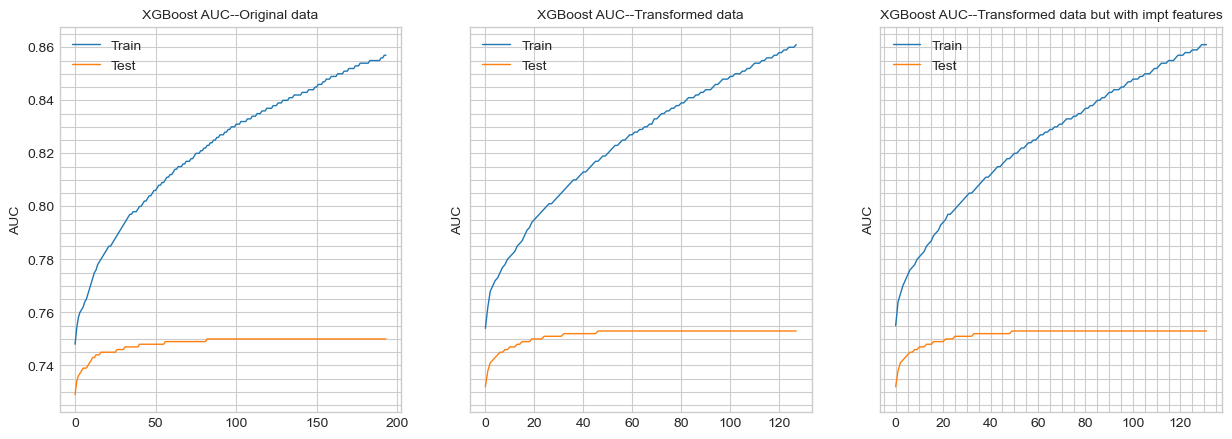

In [49]:
# 12.0 Learning curves of all the three models

plt.style.use('seaborn-v0_8-whitegrid')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,3, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(),model_trans_impt.evals_result() ]
title = ["XGBoost AUC--Original data", 'XGBoost AUC--Transformed data', 'XGBoost AUC--Transformed data but with impt features']

for i in range(3):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_title(title[i], fontsize = 10);

plt.show();



## Preparing for PCA--imputing data
PCAs of transformed data 

In [52]:
# 13.0 Check if any nulls in data
#       If so, we would impute using SimpleImputer:

X_train_trans.isnull().sum().sum()  # 0
X_test_trans.isnull().sum().sum()   # 61944
pca_train = X_train_trans.copy()
pca_test  = X_test_trans.copy()
_=gc.collect()

0

65342

In [53]:
# 13.1 Impute as test data has null values:

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
pca_train[:] = si.fit_transform(pca_train)
pca_test[:] = si.transform(pca_test)
end = time.time()
print("Done: ", (end-start)/60)  # 8 min

Imputing....
Done:  7.912519733111064


In [54]:
# 13.1.1 Check for nulls again:

pca_train.isnull().sum().sum()  # 0
pca_test.isnull().sum().sum()   # 0

0

0

### Save imputed data

In [55]:
# 13.2 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(Path(avazufolder) / "pca_train_imputed.pkl")
pca_test.to_pickle(Path(avazufolder) / "pca_test_imputed.pkl")

# 13.2.0 Datashapes
pca_train.shape  # (1501119, 586)/(1499049, 582)
pca_test.shape   # (500374, 586)/(499684, 582)

(1499049, 582)

(499684, 582)

### Read imputed data

In [57]:
# 13.2.1 Read back saved pca_train and pca_test data:

pca_train = pd.read_pickle(Path(avazufolder) / "pca_train_imputed.pkl")
pca_test = pd.read_pickle(Path(avazufolder) / "pca_test_imputed.pkl")

# 13.2.2 Check
pca_train.shape  # (1501119, 586)/(1499049, 582)
pca_test.shape   # (500374, 586)/(499684, 582)

(1499049, 582)

(499684, 582)

### Perform 95% PCA 

In [58]:
# 13.3 PCA with transformed train data.
#      Note that n_components = 0.95


pca = PCA(n_components= 0.95, whiten= True, random_state = None)
ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(pca_train))
pca_test = pca.transform(ss.transform(pca_test))

# 13.3.1 Check data shapes:
pca_train.shape  # (1501119, 97)/(1499049, 97)
pca_test.shape   # (500374, 97)/(499684, 97)

(1499049, 97)

(499684, 97)

In [59]:
# 13.4 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

# 13.4.1 Dataframe shapes:
pca_train.shape  # (1501119, 97)/(1499049, 97)
pca_test.shape   # (500374, 97)/(499684, 97)

(1499049, 97)

(499684, 97)

### Plotting PCA

In [60]:
# 13.5 Take a stratified sample for plotting:
#      Just 5000 samples:

_, pca_tr, _,pca_y  = train_test_split(pca_train, y_train,
                                       test_size = 5000,
                                       stratify = y_train
                                      )

# 13.5.1 Our data for plotting:
pca_tr.shape  # (5000, 97)
pca_y.shape   # (5000,)

(5000, 97)

(5000,)

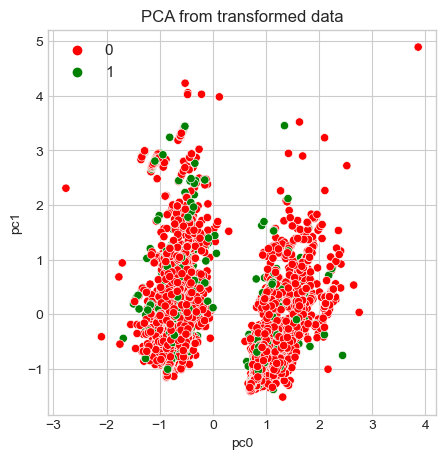

In [61]:
# 13.6 2D PCA plot from first two principal components:

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; # Set default theme
sns.scatterplot(data = pca_tr,
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data') ;

### Save PCA data

In [62]:
# 14.0 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(Path(avazufolder) / "pca_train.pkl")
pca_test.to_pickle(Path(avazufolder) / "pca_test.pkl")

### Read back PCA data

In [63]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazufolder) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazufolder) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.849631,-0.462719,0.560084,0.103338,-0.274097,-0.368581,-0.839830,0.391659,-0.459640,0.165295,...,-0.235170,0.191174,0.061168,1.091684,-0.014206,0.195178,-0.525828,0.365271,-0.450755,0.633413
1,1.155139,0.278564,0.410264,-1.244982,0.711136,2.161509,1.152552,-0.602603,1.328864,-1.608991,...,7.061366,-0.712683,0.027135,-0.952509,3.091211,1.870719,-0.473455,-3.947109,3.381505,1.684289
2,-0.679183,-0.699284,-0.083493,0.025313,-0.233486,0.085268,-0.849323,0.032845,-0.439538,0.117099,...,0.224154,-0.034428,0.339811,0.868301,-0.223116,-1.030807,-0.455839,0.140223,-0.364641,0.703816


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.771130,-0.453043,0.095163,0.557658,-0.344208,-0.033671,-0.710520,0.435808,-0.115957,1.102022,...,0.177579,-0.462857,-0.303582,-0.536073,-0.035448,-0.485754,-0.589400,0.886848,-0.017880,-0.268141
1,-0.752837,-0.339575,0.088783,-1.141025,-0.199802,0.185162,0.043599,0.124799,-1.227015,0.896823,...,-0.518168,-0.111798,0.725304,-0.462391,-0.174001,-0.462952,1.012376,-1.013665,-0.281133,-0.180926
2,-0.827908,-0.954810,-0.000639,-0.099604,0.415293,-0.110808,0.136972,-0.378553,-1.093366,0.855857,...,-0.710794,0.551108,0.100063,0.058558,-0.215256,-0.200750,0.266654,-0.267910,0.074544,0.263067


### xgboost modeling with all the PCA components

In [64]:
# 15.0 Prepare xgboost model--PCA data

# 15.0.1 We use class weights also:
#        Actually there is no benefit:

class_weights = {0: 1, 1: 10}

model_pca = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 15,
                           subsample = 0.8,
                           class_weight = class_weights,   
                           random_state = rng,
                           )


tr_X =   pca_train
test_X = pca_test
ytrain = y_train     
ytest = y_test       


model_pca.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   # 10% of n_estimators
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[09:56:51] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[09:56:51] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:57:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8400 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.73488	validation_1-auc:0.70533
[09:57:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8350 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75003	validation_1-auc:0.71597
[09:57:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8466 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.75614	validation_1-auc:0.71903
[09:57:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1

[35]	validation_0-auc:0.81170	validation_1-auc:0.73439
[10:02:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9694 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.81310	validation_1-auc:0.73453
[10:02:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10146 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.81450	validation_1-auc:0.73468
[10:03:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8372 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.81544	validation_1-auc:0.73480
[10:03:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9274 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.81682	validation_1-auc:0.73506
[10:03:20] INFO: C:\Users\dev-admin\croo

[10:08:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8006 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.85275	validation_1-auc:0.73691
[10:08:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8394 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.85391	validation_1-auc:0.73691
[10:08:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6030 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.85466	validation_1-auc:0.73695
[10:08:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5774 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.85536	validation_1-auc:0.73697
[10:09:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[108]	validation_0-auc:0.88280	validation_1-auc:0.73670
[10:14:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5452 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.88352	validation_1-auc:0.73669
[10:14:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4348 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.88406	validation_1-auc:0.73667
[10:14:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4170 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.88451	validation_1-auc:0.73665
[10:15:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6694 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.88543	validation_1-auc:0.73666
[10:15:16] INFO: C:\Users\dev-admin\

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 1, 1: 10}, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False, eta=0.06,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [65]:
# 15.1 Best Scores:

model_pca.best_score     # 0.737592962/0.737141317(40L)
model_pca.best_iteration # 62/87

0.737141317285733

87

### Classification report
xgboost modeling with PCA data

In [66]:
# 15.2 Classification report of model with PCA data:

pred = model_pca.predict(test_X)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.57      0.08      0.14     84806

    accuracy                           0.83    499684
   macro avg       0.70      0.53      0.52    499684
weighted avg       0.79      0.83      0.78    499684



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    352805
           1       0.57      0.08      0.14     72357

    accuracy                           0.83    425162
   macro avg       0.71      0.53      0.52    425162
weighted avg       0.79      0.83      0.78    425162

               precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.57      0.08      0.14     84806

    accuracy                           0.83    499684
   macro avg       0.70      0.53      0.52    499684
weighted avg       0.79      0.83      0.78    499684



"""

### Learning curve
xgboost modeling with PCA data

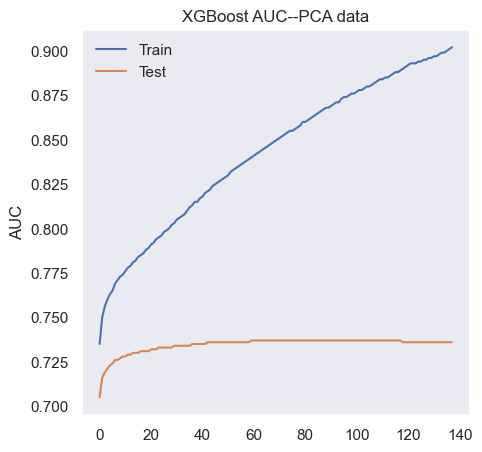

In [67]:
# 15.3 Learning curve of xgboost based on pca data:
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,1, figsize = (5,5));

results = model_pca.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs);
ax.plot(x_axis, np.round(results['validation_0']['auc'],3), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3), label='Test');
ax.legend();
ax.grid();
ax.set_ylabel('AUC');
ax.set_title("XGBoost AUC--PCA data");

## Balanacing PCA train data with `imblearn` library
We use imblearn library
>Balance with [`EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)<br>
>Balance with [`SMOTEENN`](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)<br>

In [68]:
# 16.0 Call imblearn library:

from imblearn.under_sampling import EditedNearestNeighbours   # This works with full PCA
from imblearn.combine import SMOTEENN

## Using `EditedNearestNeighbours`

In [69]:
# 16.1 Undersample PCA train data:

start = time.time()
undersample = EditedNearestNeighbours()   
X_res, y_res = undersample.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 29min

# 16.1.1 Data shape
X_res.shape  #  (1075328, 97)/(1074577, 97)
y_res.shape  #  (1075328,)/(1074577, )

29.091054594516756


(1074577, 97)

(1074577,)

### Plot of Ist two components of cleanedup data

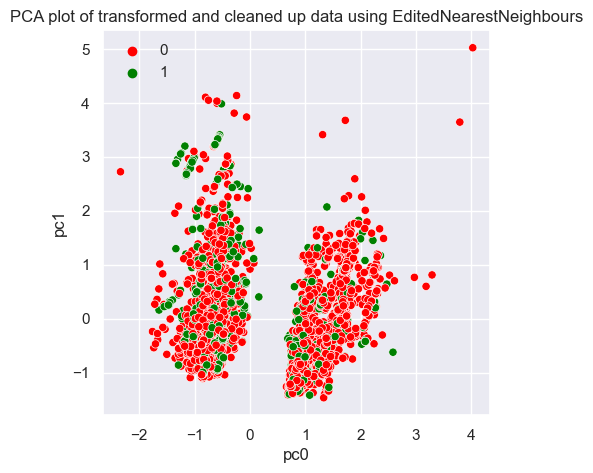

In [70]:
# 17.0 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 5000, stratify = y_res)
pca_tr.shape  # (5000, 71)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA plot of transformed and cleaned up data using EditedNearestNeighbours') ;

### xgboost modeling with undersampled data

In [71]:
# 17.3 xgboost Modeling with undersampled data

model_en = xgb.XGBClassifier( n_estimators= 500,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 15,
                               subsample = 0.9,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_en.fit(tr_X, ytrain.values,                  
          early_stopping_rounds = 100,   
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    
          )



[10:53:35] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[10:53:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8070 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.81646	validation_1-auc:0.70812
[10:53:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8076 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.82923	validation_1-auc:0.71638
[10:53:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7950 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.83568	validation_1-auc:0.72036
[10:54:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8014 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.83979	vali

[35]	validation_0-auc:0.88636	validation_1-auc:0.73460
[10:57:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9234 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.88755	validation_1-auc:0.73473
[10:57:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9064 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.88853	validation_1-auc:0.73480
[10:58:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10146 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.88981	validation_1-auc:0.73494
[10:58:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8250 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.89065	validation_1-auc:0.73504
[10:58:14] INFO: C:\Users\dev-admin\croo

[11:01:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8426 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.92011	validation_1-auc:0.73647
[11:02:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5378 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.92049	validation_1-auc:0.73646
[11:02:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7682 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.92129	validation_1-auc:0.73648
[11:02:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8158 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.92207	validation_1-auc:0.73646
[11:02:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[108]	validation_0-auc:0.94605	validation_1-auc:0.73572
[11:06:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6642 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.94649	validation_1-auc:0.73569
[11:06:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8912 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.94719	validation_1-auc:0.73565
[11:06:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3952 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.94747	validation_1-auc:0.73566
[11:06:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8644 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.94820	validation_1-auc:0.73563
[11:06:52] INFO: C:\Users\dev-admin\

[11:10:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8262 extra nodes, 0 pruned nodes, max_depth=15
[145]	validation_0-auc:0.96109	validation_1-auc:0.73476
[11:10:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7146 extra nodes, 0 pruned nodes, max_depth=15
[146]	validation_0-auc:0.96159	validation_1-auc:0.73472
[11:10:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4496 extra nodes, 0 pruned nodes, max_depth=15
[147]	validation_0-auc:0.96185	validation_1-auc:0.73469
[11:11:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7590 extra nodes, 0 pruned nodes, max_depth=15
[148]	validation_0-auc:0.96232	validation_1-auc:0.73464
[11:11:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [72]:
# 17.4 Scores:

model_en.best_score     # 0.738117/0.736502619035(40L)
model_en.best_iteration # 78/70

0.7365026190354061

70

### Classification report
After balancing data with `EditedNearestNeighbours` class

In [73]:
# 17.5 Classification report xgboost model with undersampled PCA data:

pred = model_en.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87    414878
           1       0.36      0.38      0.37     84806

    accuracy                           0.78    499684
   macro avg       0.62      0.62      0.62    499684
weighted avg       0.79      0.78      0.78    499684



In [ ]:
"""
                precision    recall  f1-score   support 

           0       0.87      0.86      0.87    415242
           1       0.36      0.39      0.38     85132

    accuracy                           0.78    500374
   macro avg       0.62      0.62      0.62    500374
weighted avg       0.79      0.78      0.78    500374

iter2
=====
               precision    recall  f1-score   support

           0       0.87      0.86      0.87    414878
           1       0.36      0.38      0.37     84806

    accuracy                           0.78    499684
   macro avg       0.62      0.62      0.62    499684
weighted avg       0.79      0.78      0.78    499684

"""

## Using `SMOTEENN`
For balancing PCA data

In [75]:
# 18.0 Instantiate SMOTEEN and use it on pca_train

start= time.time()
sm = SMOTEENN(random_state=rng)
X_res, y_res = sm.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 60 min(15L), 97min(20L), 97(40L)


# 18.0.1 Data shape after SMOTEENN

X_res.shape  # (1688427, 97)/(1683565, 97)
y_res.shape  # (1688427,),(1683565,)

97.85490277210872


(1683565, 97)

(1683565,)

In [76]:
# 18.0.2
y_res.value_counts()
y_res.value_counts(normalize = True)  # 57%:43%

1    965968
0    717597
Name: click, dtype: int64

1    0.573763
0    0.426237
Name: click, dtype: float64

### Plot of Ist two components of cleanedup data

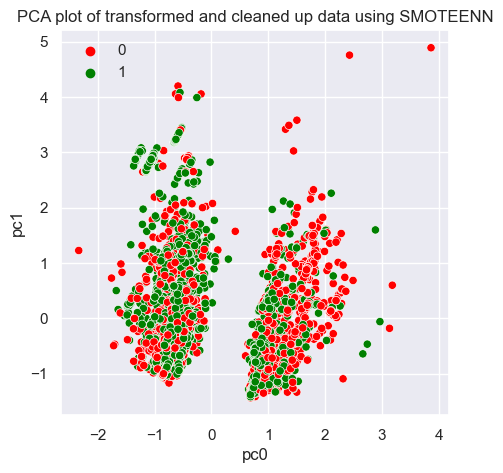

In [77]:
# 18.0.3 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 5000, stratify = y_res)
pca_tr.shape  # (5000, 71)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA plot of transformed and cleaned up data using SMOTEENN') ;

### xgboost modeling with balanced data (SMOTEENN)

In [78]:
# 19.0 Modeling with smoteenn data

model_sm = xgb.XGBClassifier( n_estimators= 500,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 15,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_sm.fit(tr_X, ytrain.values,                  
                early_stopping_rounds = 100,   
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']    
                )



[15:57:01] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:57:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8724 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.86131	validation_1-auc:0.70609
[15:57:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8426 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.87733	validation_1-auc:0.71661
[15:57:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8486 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.88250	validation_1-auc:0.71939
[15:57:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8492 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.88558	vali

[35]	validation_0-auc:0.92231	validation_1-auc:0.73032
[16:04:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10148 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.92332	validation_1-auc:0.73047
[16:04:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9978 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.92438	validation_1-auc:0.73050
[16:04:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10222 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.92540	validation_1-auc:0.73066
[16:04:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10306 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.92626	validation_1-auc:0.73069
[16:05:05] INFO: C:\Users\dev-admin\cr

[16:11:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 13374 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.94797	validation_1-auc:0.73025
[16:11:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10440 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.94865	validation_1-auc:0.73019
[16:11:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10914 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.94928	validation_1-auc:0.73014
[16:11:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 12888 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.95025	validation_1-auc:0.73018
[16:12:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

[108]	validation_0-auc:0.97060	validation_1-auc:0.72924
[16:18:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 12636 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.97119	validation_1-auc:0.72921
[16:18:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9900 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.97163	validation_1-auc:0.72918
[16:18:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11576 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.97225	validation_1-auc:0.72917
[16:19:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7334 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.97244	validation_1-auc:0.72912
[16:19:20] INFO: C:\Users\dev-admi

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [284]:
# 19.1 score
model_sm.best_score   # 0.7320805711/0.732080571166006(40L)
model_sm.best_iteration  # 33

0.7320805711660064

33

### Classification report
After balancing with `SMOTEENN` class 

In [79]:
# 19.2 
pred = model_sm.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.55      0.69    414878
           1       0.26      0.79      0.40     84806

    accuracy                           0.59    499684
   macro avg       0.60      0.67      0.54    499684
weighted avg       0.81      0.59      0.64    499684



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.93      0.54      0.69    415242
           1       0.26      0.79      0.40     85132

    accuracy                           0.59    500374
   macro avg       0.60      0.67      0.54    500374
weighted avg       0.82      0.59      0.64    500374


               precision    recall  f1-score   support

           0       0.93      0.55      0.69    414878
           1       0.26      0.79      0.40     84806

    accuracy                           0.59    499684
   macro avg       0.60      0.67      0.54    499684
weighted avg       0.81      0.59      0.64    499684

"""

### Learning plots
xgboost modeling with the two class balancing techniques

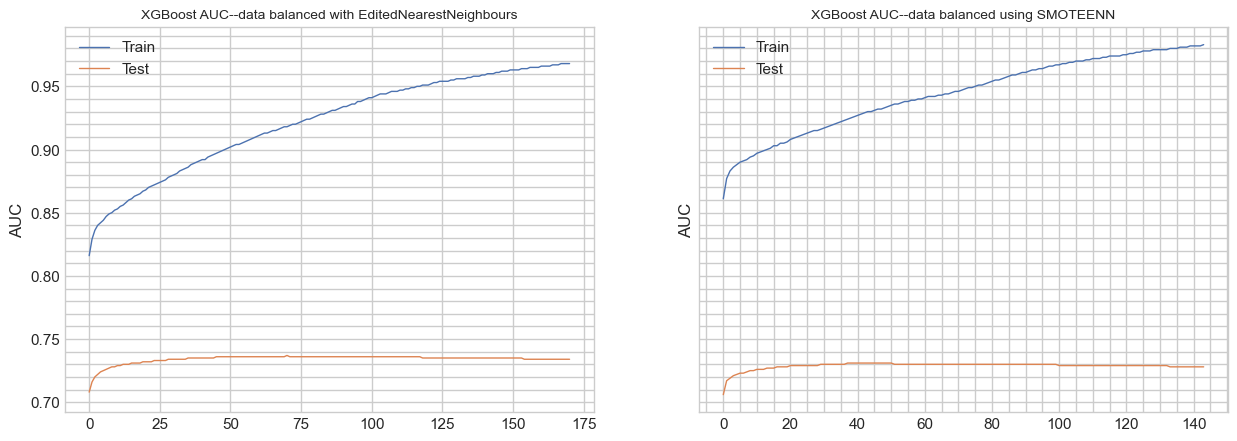

In [80]:
# 19.3 Learning curves: xgboost modeling"

plt.style.use('seaborn-v0_8-whitegrid')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (15,5), sharey = True);
results = [model_en.evals_result(),model_sm.evals_result()]
title = ["XGBoost AUC--data balanced with EditedNearestNeighbours", 'XGBoost AUC--data balanced using SMOTEENN']

for i in range(2):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_title(title[i], fontsize = 10);

plt.show();

## Distribution of transformed features:

eigenvector          0.3750
degree               0.3125
pagerank             0.3125
clusteringcoeff      0.0000
betweenness          0.0000
avgembeddedness      0.0000
leidencomsdensity    0.0000
dtype: float64

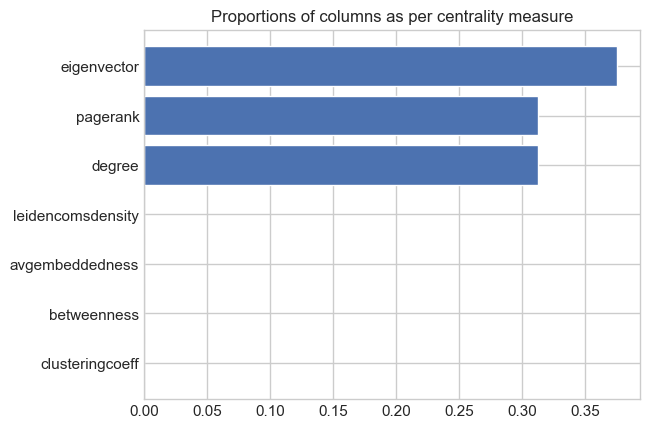

In [81]:
# Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

# 20.0 Our list of columns

colList = X_train_trans.columns

# 20.0.1 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")


### Proportions of columns by centrality whose impt is > 0

In [82]:
# 20.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"

Order of feature importance is by 'gain'


'Columns whose impt is >0: 405'

'Columns whose impt is 0: 177'

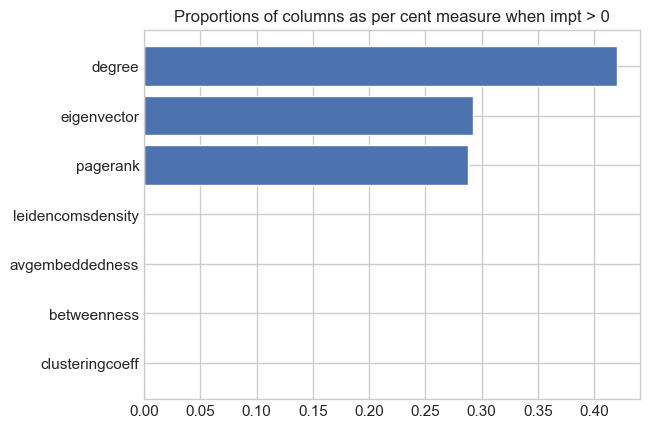

In [83]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")



### Proportions of columns by summed-up importance score of each centrality measure

Order of feature importance is by 'gain'


eig_Cfourteen_ck_Ceighteen       0.279218
pr_Ctwentyone_ck_devicemodel     0.132857
deg_Ctwentyone_ck_devicemodel    0.049986
deg_Cseventeen_ck_Csixteen       0.030009
eig_appid_ck_devicemodel         0.018302
Name: imp, dtype: float32

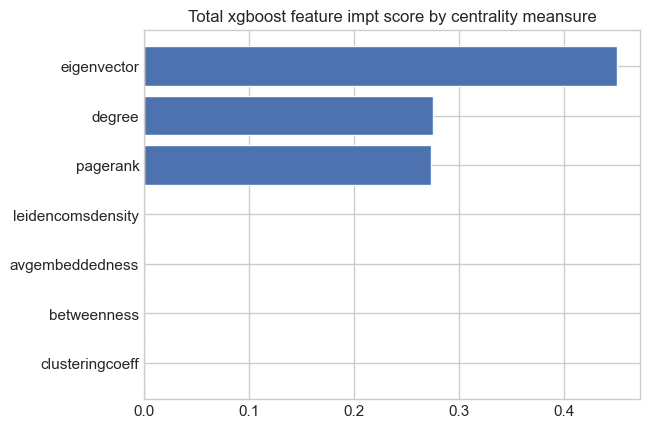

In [84]:
# 20.3 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)

# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs
Deriving features directly from graphs


In [86]:
# 21.0 Path where .gml files are placed:

pathToFolder = graphfolder
filelist = sorted(list(pathToFolder.iterdir()))
filelist[5:10]   # mgrid_bigraph_*


[WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cfourteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cnineteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cone.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cseventeen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Csixteen.gml')]

### Read back data files

In [304]:
# 21.1
avazufolder = 'D:\\avazu\\allmodels\\data\\'

In [87]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazufolder) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazufolder) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazufolder) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazufolder) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazufolder) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1501119, 599)
y_train.shape       # (1501119,)
test_trans.shape    # (500374, 599)
y_test.shape        # (500374,)

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'device_id',
            'device_ip', 'hour_time', 'month']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)
                           
# 21.6 Check
X_train_trans.shape  # (1501119, 586)
X_test_trans.shape   # (500374, 586)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,1,2212,2225,20,3625,110,0,1981,1,...,0.167377,0.881356,0.159990,0.021333,0.728814,2.019105e-01,0.034772,1.000000,0.145802,0.021031
1,1005,0,1591,2714,5,917,27,3,975,1,...,-0.042770,0.694915,0.141788,0.016860,0.000000,-1.384875e-17,0.002650,0.864407,0.138035,0.017952


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,379,3342,1,3625,110,0,1335,1,...,0.167377,0.881356,0.159990,0.021333,0.728814,0.201910,0.034772,1.000000,0.145802,0.021031
1,1005,0,379,3342,1,3625,110,0,3741,1,...,0.224367,0.898305,0.156404,0.022265,0.525424,0.177471,0.023484,0.983051,0.145187,0.020582


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,1,2212,2225,20,3625,110,0,184092,166934,...,50,2528,0,39,-1,221,10,1,28,11
1,1005,0,1591,2714,5,917,27,3,194319,315868,...,50,1895,0,681,100028,101,10,1,21,4


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,379,3342,1,3625,110,0,184092,150488,...,50,2545,0,167,-1,221,10,1,28,7
1,1005,0,379,3342,1,3625,110,0,184092,404402,...,50,2299,2,1327,-1,52,10,5,25,17


(1499049, 595)

(1499049,)

(499684, 595)

(499684,)

(1499049, 582)

(499684, 582)

In [90]:
# 22.0 Get sample list of projected and bigraphs:

projected = [str(i).split("\\")[-1] for i in filelist if 'appcategory_projected' in str(i)]
bigraphs = [str(i).split("\\")[-1] for i in filelist if 'appcategory_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['appcategory_bigraph_Cone.gml',
 'appcategory_bigraph_appid.gml',
 'appcategory_bigraph_siteid.gml',
 'appcategory_bigraph_Ctwenty.gml',
 'appcategory_bigraph_Cfifteen.gml',
 'appcategory_bigraph_Csixteen.gml',
 'appcategory_bigraph_appdomain.gml',
 'appcategory_bigraph_bannerpos.gml']



====



['appcategory_projected_Cone.gml',
 'appcategory_projected_appid.gml',
 'appcategory_projected_siteid.gml',
 'appcategory_projected_Ctwenty.gml',
 'appcategory_projected_Cfifteen.gml',
 'appcategory_projected_Csixteen.gml',
 'appcategory_projected_appdomain.gml',
 'appcategory_projected_bannerpos.gml']

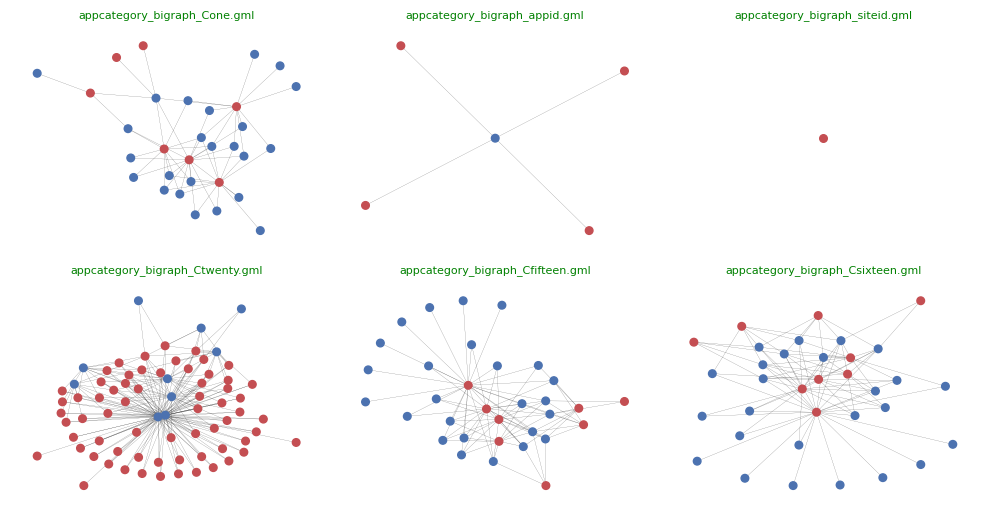

In [91]:
# 22.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                 pathToFolder,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

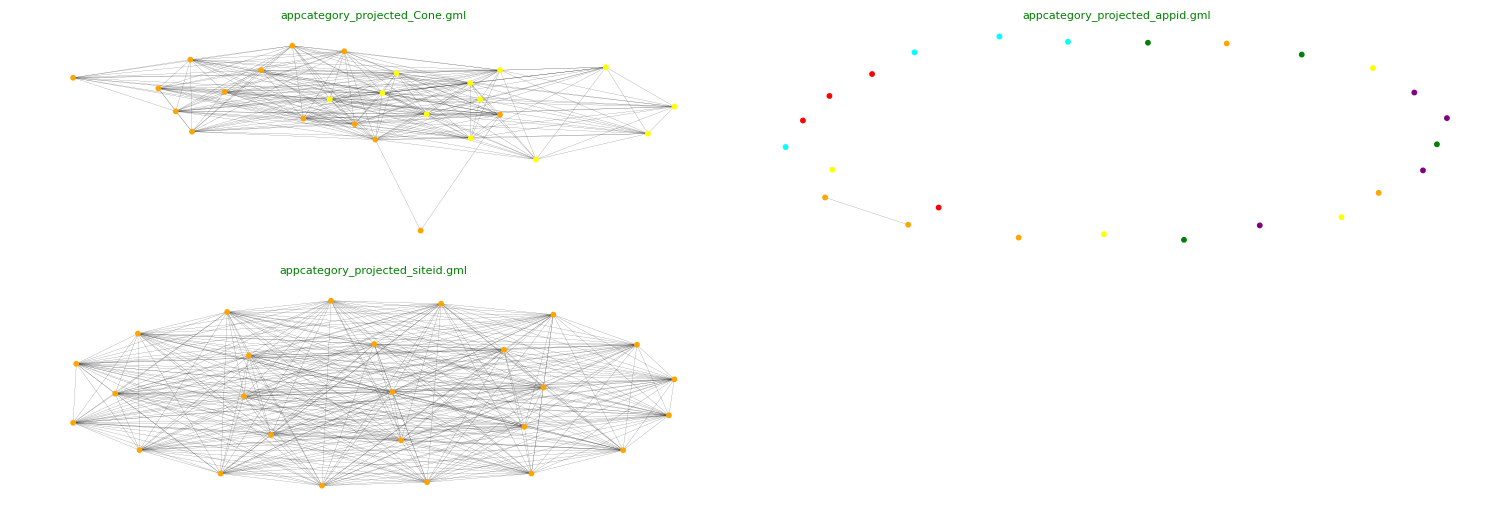

In [92]:
# 22.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   pathToFolder,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

In [93]:
# 23.0 Transform each column bin as per the community
#       to which it belongs:

# 23.1 Our transformed discrete cols are:
columnNames = cat_cols

# 23.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 23.3 Graph files are within:
#pathToGraphFolder= Path("D:\\avazu\\allmodels\\models\\")

# 23.4 Perform transformation of both train_binned and test_binend:
# 23.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 23.4.2 PErform transformation to community structure
#  Takes lots of time...

for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,graphfolder,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,graphfolder,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)


..Transforming train data....

Reading file:  siteid_projected_Cone.gml
Reading file:  siteid_projected_bannerpos.gml
Reading file:  siteid_projected_sitedomain.gml
Reading file:  siteid_projected_sitecategory.gml
Reading file:  siteid_projected_appid.gml
Reading file:  siteid_projected_appdomain.gml
Reading file:  siteid_projected_appcategory.gml
Reading file:  siteid_projected_devicemodel.gml
Reading file:  siteid_projected_devicetype.gml
Reading file:  siteid_projected_deviceconntype.gml
Reading file:  siteid_projected_Cfourteen.gml
Reading file:  siteid_projected_Cfifteen.gml
Reading file:  siteid_projected_Csixteen.gml
Reading file:  siteid_projected_Cseventeen.gml
Reading file:  siteid_projected_Ceighteen.gml
Reading file:  siteid_projected_Cnineteen.gml
Reading file:  siteid_projected_Ctwenty.gml
Reading file:  siteid_projected_Ctwentyone.gml
Reading file:  sitedomain_projected_Cone.gml
Reading file:  sitedomain_projected_bannerpos.gml
Reading file:  sitedomain_projected_siteid

Reading file:  Cnineteen_projected_siteid.gml
Reading file:  Cnineteen_projected_sitedomain.gml
Reading file:  Cnineteen_projected_sitecategory.gml
Reading file:  Cnineteen_projected_appid.gml
Reading file:  Cnineteen_projected_appdomain.gml
Reading file:  Cnineteen_projected_appcategory.gml
Reading file:  Cnineteen_projected_devicemodel.gml
Reading file:  Cnineteen_projected_devicetype.gml
Reading file:  Cnineteen_projected_deviceconntype.gml
Reading file:  Cnineteen_projected_Cfourteen.gml
Reading file:  Cnineteen_projected_Cfifteen.gml
Reading file:  Cnineteen_projected_Csixteen.gml
Reading file:  Cnineteen_projected_Cseventeen.gml
Reading file:  Cnineteen_projected_Ceighteen.gml
Reading file:  Cnineteen_projected_Ctwenty.gml
Reading file:  Cnineteen_projected_Ctwentyone.gml
Reading file:  Ctwenty_projected_Cone.gml
Reading file:  Ctwenty_projected_bannerpos.gml
Reading file:  Ctwenty_projected_siteid.gml
Reading file:  Ctwenty_projected_sitedomain.gml
Reading file:  Ctwenty_project

Reading file:  devicemodel_projected_sitecategory.gml
Reading file:  devicemodel_projected_appid.gml
Reading file:  devicemodel_projected_appdomain.gml
Reading file:  devicemodel_projected_appcategory.gml
Reading file:  devicemodel_projected_devicetype.gml
Reading file:  devicemodel_projected_deviceconntype.gml
Reading file:  devicemodel_projected_Cfourteen.gml
Reading file:  devicemodel_projected_Cfifteen.gml
Reading file:  devicemodel_projected_Csixteen.gml
Reading file:  devicemodel_projected_Cseventeen.gml
Reading file:  devicemodel_projected_Ceighteen.gml
Reading file:  devicemodel_projected_Cnineteen.gml
Reading file:  devicemodel_projected_Ctwenty.gml
Reading file:  devicemodel_projected_Ctwentyone.gml
Reading file:  Cfourteen_projected_Cone.gml
Reading file:  Cfourteen_projected_bannerpos.gml
Reading file:  Cfourteen_projected_siteid.gml
Reading file:  Cfourteen_projected_sitedomain.gml
Reading file:  Cfourteen_projected_sitecategory.gml
Reading file:  Cfourteen_projected_appid

In [94]:
# 24.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (1501119, 212)/(1499049, 212)
print("\n--\n")
fg_te[0].shape   # (500374, 212)/(499684, 212)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(1499049, 212)


--



(499684, 212)


--



,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,1,1,721,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,2,1,1,0,1,0,0,2,1,1,...,0,0,1,1,0,0,1,0,3,1


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,1.0,0.0,1092.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,1
1,1.0,0.0,1092.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,1,1


In [95]:
# 24.1 Remove constant columns from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 24.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (1499049, 212)
Datashape after processing: (1499049, 159)


In [96]:
# 24.2 Save the list to gdrive:

utils.savePythonObject(fg_tr, "fg_tr.pkl", avazufolder)
utils.savePythonObject(fg_te, "fg_te.pkl", avazufolder)

Object saved to: D:\avazu\allmodels\data\fg_tr.pkl
Object saved to: D:\avazu\allmodels\data\fg_te.pkl


In [97]:
# 24.3

fg_tr = utils.restorePythonObject( "fg_tr.pkl", avazufolder )
fg_te = utils.restorePythonObject( "fg_te.pkl", avazufolder )
fg_tr[0].shape  # (1501119, 161)/(1499049, 159)
fg_te[0].shape  # (500374, 161)/(499684, 159)

(1499049, 159)

(499684, 159)

In [98]:
# 24.4 Check restoration:

fg_tr[0].head(2)
fg_te[0].head(2)

,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,1,1,721,1,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
1,2,1,1,0,1,2,1,1,0,1,...,1,0,1,0,1,1,1,0,3,1


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,1.0,0.0,1092.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1
1,1.0,0.0,1092.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,1,1


## xgboost modeling with data transformed through community classes

In [99]:
# 25.0 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 250,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 13,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 50,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[18:24:03] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:24:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3604 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.73320	validation_1-auc:0.72764
[18:24:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3542 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.73600	validation_1-auc:0.72964
[18:24:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3562 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.73737	validation_1-auc:0.73047
[18:24:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3598 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.73822	vali

[18:25:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4108 extra nodes, 0 pruned nodes, max_depth=13
[36]	validation_0-auc:0.75257	validation_1-auc:0.73975
[18:25:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4494 extra nodes, 0 pruned nodes, max_depth=13
[37]	validation_0-auc:0.75285	validation_1-auc:0.73991
[18:25:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4452 extra nodes, 0 pruned nodes, max_depth=13
[38]	validation_0-auc:0.75309	validation_1-auc:0.74001
[18:25:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4606 extra nodes, 0 pruned nodes, max_depth=13
[39]	validation_0-auc:0.75341	validation_1-auc:0.74012
[18:26:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[72]	validation_0-auc:0.76072	validation_1-auc:0.74288
[18:27:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2584 extra nodes, 0 pruned nodes, max_depth=13
[73]	validation_0-auc:0.76090	validation_1-auc:0.74294
[18:27:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2352 extra nodes, 0 pruned nodes, max_depth=13
[74]	validation_0-auc:0.76099	validation_1-auc:0.74299
[18:27:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2532 extra nodes, 0 pruned nodes, max_depth=13
[75]	validation_0-auc:0.76115	validation_1-auc:0.74303
[18:27:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3876 extra nodes, 0 pruned nodes, max_depth=13
[76]	validation_0-auc:0.76152	validation_1-auc:0.74317
[18:27:50] INFO: C:\Users\dev-admin\croot

[18:29:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2106 extra nodes, 0 pruned nodes, max_depth=13
[109]	validation_0-auc:0.76804	validation_1-auc:0.74454
[18:29:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3808 extra nodes, 0 pruned nodes, max_depth=13
[110]	validation_0-auc:0.76833	validation_1-auc:0.74461
[18:29:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1530 extra nodes, 0 pruned nodes, max_depth=13
[111]	validation_0-auc:0.76839	validation_1-auc:0.74460
[18:29:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3080 extra nodes, 0 pruned nodes, max_depth=13
[112]	validation_0-auc:0.76860	validation_1-auc:0.74464
[18:29:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

[145]	validation_0-auc:0.77287	validation_1-auc:0.74499
[18:30:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1028 extra nodes, 0 pruned nodes, max_depth=13
[146]	validation_0-auc:0.77292	validation_1-auc:0.74499
[18:31:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 798 extra nodes, 0 pruned nodes, max_depth=13
[147]	validation_0-auc:0.77297	validation_1-auc:0.74499
[18:31:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1658 extra nodes, 0 pruned nodes, max_depth=13
[148]	validation_0-auc:0.77304	validation_1-auc:0.74500
[18:31:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1854 extra nodes, 0 pruned nodes, max_depth=13
[149]	validation_0-auc:0.77316	validation_1-auc:0.74502
[18:31:09] INFO: C:\Users\dev-admin\c

[18:32:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1454 extra nodes, 0 pruned nodes, max_depth=13
[182]	validation_0-auc:0.77663	validation_1-auc:0.74502
[18:32:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2254 extra nodes, 0 pruned nodes, max_depth=13
[183]	validation_0-auc:0.77674	validation_1-auc:0.74502
[18:32:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3140 extra nodes, 0 pruned nodes, max_depth=13
[184]	validation_0-auc:0.77689	validation_1-auc:0.74502
[18:32:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1842 extra nodes, 0 pruned nodes, max_depth=13
[185]	validation_0-auc:0.77698	validation_1-auc:0.74502
[18:32:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

[218]	validation_0-auc:0.77973	validation_1-auc:0.74491
[18:34:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3010 extra nodes, 0 pruned nodes, max_depth=13
[219]	validation_0-auc:0.77987	validation_1-auc:0.74491
[18:34:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2518 extra nodes, 0 pruned nodes, max_depth=13
[220]	validation_0-auc:0.77997	validation_1-auc:0.74492
[18:34:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2944 extra nodes, 0 pruned nodes, max_depth=13
[221]	validation_0-auc:0.78015	validation_1-auc:0.74491
[18:34:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1306 extra nodes, 0 pruned nodes, max_depth=13
[222]	validation_0-auc:0.78020	validation_1-auc:0.74491
[18:34:26] INFO: C:\Users\dev-admin\

[18:35:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2576 extra nodes, 0 pruned nodes, max_depth=13
[255]	validation_0-auc:0.78272	validation_1-auc:0.74468
[18:35:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1748 extra nodes, 0 pruned nodes, max_depth=13
[256]	validation_0-auc:0.78279	validation_1-auc:0.74466
[18:35:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2122 extra nodes, 0 pruned nodes, max_depth=13
[257]	validation_0-auc:0.78288	validation_1-auc:0.74466
[18:36:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2280 extra nodes, 0 pruned nodes, max_depth=13
[258]	validation_0-auc:0.78298	validation_1-auc:0.74465
[18:36:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve

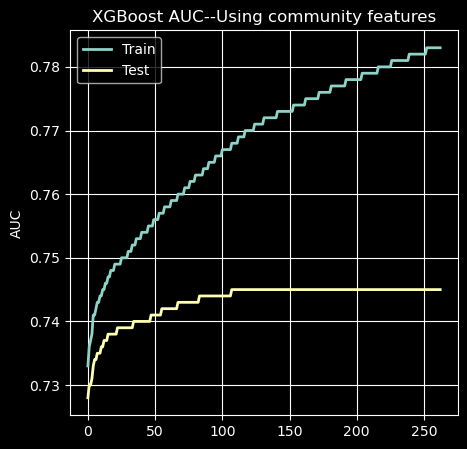

In [101]:
# 25.1 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using community features");


#### Classification report

In [102]:
# 25.2 Classification reports:

pred_comm = model_trans_commu.predict(test_X)
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")


Classification report from community data: 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.60      0.08      0.14     84806

    accuracy                           0.83    499684
   macro avg       0.72      0.54      0.53    499684
weighted avg       0.80      0.83      0.78    499684



## PCA of transformed community indicators

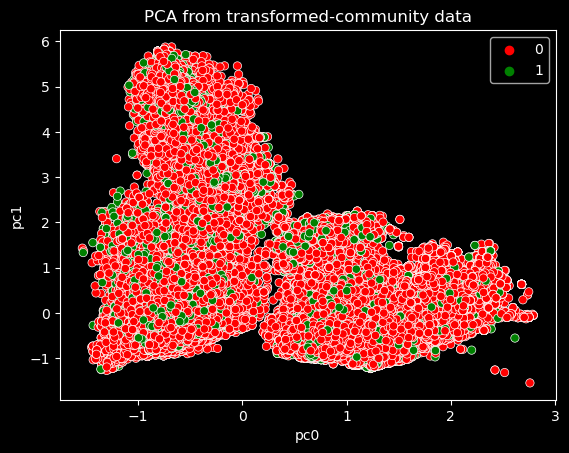

In [103]:
# 25.3 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

# 25.4 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))

# 25.5 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 25.6 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x=  commu_pca.pc0,
                y = commu_pca.pc1,
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

In [104]:
gc.collect()

9533

## Derive unit-vectors per level per cat column

In [ ]:
##*****************************
## Embedding Projector
## Incidentally f1-score is highest
##*****************************

In [105]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazufolder) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazufolder) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazufolder) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazufolder) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazufolder) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1501119, 599)
y_train.shape       # (1501119,)
test_trans.shape    # (500374, 599)
y_test.shape        # (500374,)

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'device_id',
            'device_ip', 'hour_time', 'month']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)
                           
# 21.6 Check
X_train_trans.shape  # (1501119, 586)
X_test_trans.shape   # (500374, 586)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,1,2212,2225,20,3625,110,0,1981,1,...,0.167377,0.881356,0.159990,0.021333,0.728814,2.019105e-01,0.034772,1.000000,0.145802,0.021031
1,1005,0,1591,2714,5,917,27,3,975,1,...,-0.042770,0.694915,0.141788,0.016860,0.000000,-1.384875e-17,0.002650,0.864407,0.138035,0.017952


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,379,3342,1,3625,110,0,1335,1,...,0.167377,0.881356,0.159990,0.021333,0.728814,0.201910,0.034772,1.000000,0.145802,0.021031
1,1005,0,379,3342,1,3625,110,0,3741,1,...,0.224367,0.898305,0.156404,0.022265,0.525424,0.177471,0.023484,0.983051,0.145187,0.020582


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,1,2212,2225,20,3625,110,0,184092,166934,...,50,2528,0,39,-1,221,10,1,28,11
1,1005,0,1591,2714,5,917,27,3,194319,315868,...,50,1895,0,681,100028,101,10,1,21,4


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,379,3342,1,3625,110,0,184092,150488,...,50,2545,0,167,-1,221,10,1,28,7
1,1005,0,379,3342,1,3625,110,0,184092,404402,...,50,2299,2,1327,-1,52,10,5,25,17


(1499049, 595)

(1499049,)

(499684, 595)

(499684,)

(1499049, 582)

(499684, 582)

In [106]:

# 21.2 Check for nulls:
train_trans.isnull().sum().sum()  # 0
print("---")
test_trans.isnull().sum().sum()   # 65342

0

---


65342

In [107]:
# 21.3 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()


SimpleImputer(strategy='median')

0

In [108]:
'target' in list(train_trans.columns)
'target' in list(test_trans.columns)

False

False

In [112]:
# 21.4 Get target data col.
#      Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

# 22.0 Derive unit vectors:

p = Path(unitvecfolder)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = unitvecfolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 22.1 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = unitvecfolder,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for bannerpos
Checked for siteid
Checked for sitedomain
Checked for sitecategory
Checked for appid
Checked for appdomain
Checked for appcategory
Checked for devicemodel
Checked for devicetype
Checked for deviceconntype
Checked for Cfourteen
Checked for Cfifteen
Checked for Csixteen
Checked for Cseventeen
Checked for Ceighteen
Checked for Cnineteen
Checked for Ctwenty
Checked for Ctwentyone
For these columns we do not have vectors:  ['Cone', 'bannerpos', 'devicetype', 'deviceconntype', 'Cfifteen', 'Csixteen', 'Ceighteen']
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'D:\avazu\allmodels\unitvecfolder'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked 

## Save unit-vectors files to gdrive
Also save output dictionaries for later use


In [113]:
# 22.2 Save dict to gdrive:

utils.savePythonObject(vec_tr, "vec_tr.pkl", unitvecfolder)
utils.savePythonObject(vec_te, "vec_te.pkl",unitvecfolder)


Object saved to: D:\avazu\allmodels\unitvecfolder\vec_tr.pkl
Object saved to: D:\avazu\allmodels\unitvecfolder\vec_te.pkl


## Restore unit-vectors files from gdrive

In [114]:
# 22.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", unitvecfolder)
vec_te = utils.restorePythonObject("vec_te.pkl",unitvecfolder)

In [116]:
## Using unit vectors to transform train/test data

# 23.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


# 23.1

cctr.head(3)
ccte.head(3)


Performing PCA for siteid for train data
Performing PCA for siteid for test data
Performing PCA for sitedomain for train data
Performing PCA for sitedomain for test data
Performing PCA for sitecategory for train data
Performing PCA for sitecategory for test data
Performing PCA for appid for train data
Performing PCA for appid for test data
Performing PCA for appdomain for train data
Performing PCA for appdomain for test data
Performing PCA for appcategory for train data
Performing PCA for appcategory for test data
Performing PCA for devicemodel for train data
Performing PCA for devicemodel for test data
Performing PCA for Cfourteen for train data
Performing PCA for Cfourteen for test data
Performing PCA for Cseventeen for train data
Performing PCA for Cseventeen for test data
Performing PCA for Cnineteen for train data
Performing PCA for Cnineteen for test data
Performing PCA for Ctwenty for train data
Performing PCA for Ctwenty for test data
Performing PCA for Ctwentyone for train dat

,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,5.316208,-0.247274,-3.610626,4.685491,7.098251,-4.341729,-6.261874,4.143567,-7.759970,0.315130,...,0.129654,0.850908,-5.010280,1.395076,0.159713,-0.007612,-4.949503,-2.659382,0.241786,1.425159
1,-6.949694,0.252222,0.162800,0.452990,-6.208370,-1.202606,0.632635,0.198780,3.115088,-1.220632,...,-5.505877,-8.287860,8.575613,-1.659209,9.406816,-0.923258,3.933552,3.396859,-3.705883,0.056606
2,1.960228,-2.244287,-0.803810,-0.772093,4.754921,-1.550860,-0.621095,-2.143311,-7.757887,0.272128,...,0.203272,0.909124,-5.010833,1.399060,0.128888,-0.004793,-4.949940,-2.659459,0.233994,1.441553


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,4.279368,-1.857603,-0.548925,-0.276007,7.020648,-0.734821,0.386247,-1.319428,4.550881,-0.668952,...,-0.022006,0.777145,-5.010919,1.399046,0.128746,0.001708,-4.949959,-2.659471,0.232826,1.439889
1,4.279368,-1.857603,-0.548925,-0.276007,7.020648,-0.734821,0.386247,-1.319428,4.550881,-0.668952,...,-1.884469,2.502507,-5.010919,1.399046,0.128746,0.001708,-3.293430,-0.953089,-0.031374,1.557690
2,4.279368,-1.857603,-0.548925,-0.276007,7.020648,-0.734821,0.386247,-1.319428,4.550881,-0.668952,...,-0.061356,-0.339097,-5.010919,1.399046,0.128746,0.001708,0.193582,1.459092,0.060979,0.360268


In [117]:

# 23.2

cctr.shape   #  (1499049, 48)
ccte.shape   #  (499684, 48)


(1499049, 48)

(499684, 48)

### Save unitvectors transformed train/test


In [119]:
# 23.4 Save cctr/ccte to gdrive
cctr.to_pickle(avazufolder / "cctr.pkl")
ccte.to_pickle(avazufolder / "ccte.pkl")


### Readback unitvectors transformed train/test



In [120]:
# 24.0 Read back cctr/ccte
cctr = pd.read_pickle(avazufolder / "cctr.pkl")
ccte = pd.read_pickle(avazufolder / "ccte.pkl")

In [121]:
# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (1499049, 48)
ccte.shape # (499684, 48)


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,5.316208,-0.247274,-3.610626,4.685491,7.098251,-4.341729,-6.261874,4.143567,-7.759970,0.315130,...,0.129654,0.850908,-5.010280,1.395076,0.159713,-0.007612,-4.949503,-2.659382,0.241786,1.425159
1,-6.949694,0.252222,0.162800,0.452990,-6.208370,-1.202606,0.632635,0.198780,3.115088,-1.220632,...,-5.505877,-8.287860,8.575613,-1.659209,9.406816,-0.923258,3.933552,3.396859,-3.705883,0.056606


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,4.279368,-1.857603,-0.548925,-0.276007,7.020648,-0.734821,0.386247,-1.319428,4.550881,-0.668952,...,-0.022006,0.777145,-5.010919,1.399046,0.128746,0.001708,-4.949959,-2.659471,0.232826,1.439889
1,4.279368,-1.857603,-0.548925,-0.276007,7.020648,-0.734821,0.386247,-1.319428,4.550881,-0.668952,...,-1.884469,2.502507,-5.010919,1.399046,0.128746,0.001708,-3.293430,-0.953089,-0.031374,1.557690


(1499049, 48)

(499684, 48)

## xgboost modeling

In [122]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[19:58:00] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[19:58:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4176 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.73686	validation_1-auc:0.71127
[19:58:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3972 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.74324	validation_1-auc:0.71392
[19:58:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4258 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.74539	validation_1-auc:0.71635
[19:58:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4180 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.74661	vali

[19:59:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4986 extra nodes, 0 pruned nodes, max_depth=13
[36]	validation_0-auc:0.76508	validation_1-auc:0.73596
[19:59:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4398 extra nodes, 0 pruned nodes, max_depth=13
[37]	validation_0-auc:0.76548	validation_1-auc:0.73629
[19:59:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5226 extra nodes, 0 pruned nodes, max_depth=13
[38]	validation_0-auc:0.76607	validation_1-auc:0.73668
[19:59:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5362 extra nodes, 0 pruned nodes, max_depth=13
[39]	validation_0-auc:0.76671	validation_1-auc:0.73638
[19:59:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[72]	validation_0-auc:0.77806	validation_1-auc:0.73898
[20:00:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3260 extra nodes, 0 pruned nodes, max_depth=13
[73]	validation_0-auc:0.77836	validation_1-auc:0.73904
[20:00:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2682 extra nodes, 0 pruned nodes, max_depth=13
[74]	validation_0-auc:0.77860	validation_1-auc:0.73912
[20:00:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1920 extra nodes, 0 pruned nodes, max_depth=13
[75]	validation_0-auc:0.77873	validation_1-auc:0.73918
[20:00:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2144 extra nodes, 0 pruned nodes, max_depth=13
[76]	validation_0-auc:0.77892	validation_1-auc:0.73993
[20:00:14] INFO: C:\Users\dev-admin\croot

[20:01:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3156 extra nodes, 0 pruned nodes, max_depth=13
[109]	validation_0-auc:0.78666	validation_1-auc:0.74174
[20:01:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2506 extra nodes, 0 pruned nodes, max_depth=13
[110]	validation_0-auc:0.78695	validation_1-auc:0.74176
[20:01:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2406 extra nodes, 0 pruned nodes, max_depth=13
[111]	validation_0-auc:0.78711	validation_1-auc:0.74178
[20:01:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1558 extra nodes, 0 pruned nodes, max_depth=13
[112]	validation_0-auc:0.78728	validation_1-auc:0.74182
[20:01:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

[145]	validation_0-auc:0.79304	validation_1-auc:0.74239
[20:02:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1146 extra nodes, 0 pruned nodes, max_depth=13
[146]	validation_0-auc:0.79314	validation_1-auc:0.74241
[20:02:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1760 extra nodes, 0 pruned nodes, max_depth=13
[147]	validation_0-auc:0.79328	validation_1-auc:0.74241
[20:02:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 972 extra nodes, 0 pruned nodes, max_depth=13
[148]	validation_0-auc:0.79336	validation_1-auc:0.74242
[20:02:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2646 extra nodes, 0 pruned nodes, max_depth=13
[149]	validation_0-auc:0.79363	validation_1-auc:0.74245
[20:02:13] INFO: C:\Users\dev-admin\c

[20:03:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2488 extra nodes, 0 pruned nodes, max_depth=13
[182]	validation_0-auc:0.79760	validation_1-auc:0.74261
[20:03:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=13
[183]	validation_0-auc:0.79762	validation_1-auc:0.74261
[20:03:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1522 extra nodes, 0 pruned nodes, max_depth=13
[184]	validation_0-auc:0.79773	validation_1-auc:0.74261
[20:03:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2218 extra nodes, 0 pruned nodes, max_depth=13
[185]	validation_0-auc:0.79793	validation_1-auc:0.74264
[20:03:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [123]:
# 24.2 Best scores:

model_vec.best_score   # 0.7427288912
print("\n")
model_vec.best_iteration  # 199


0.742728891232539

199

### Classification report

In [124]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))


              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.62      0.08      0.13     84806

    accuracy                           0.84    499684
   macro avg       0.73      0.53      0.52    499684
weighted avg       0.80      0.84      0.78    499684



### Learning curve

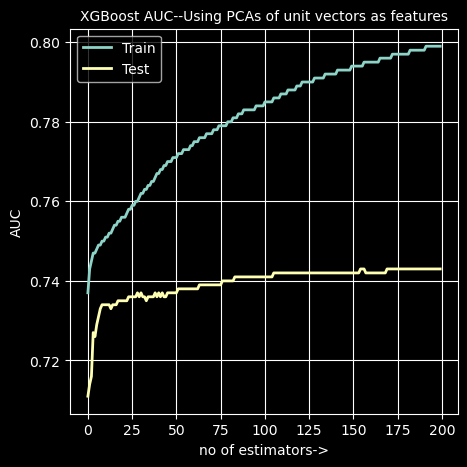

In [125]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_vec.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

## Feature Engineering with clustering

In [135]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 10,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)



Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16
Current index:  20
Current index:  24
Current index:  28
Current index:  32
Current index:  36
Current index:  40
Current index:  44


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,5.316208,-0.247274,-3.610626,4.685491,7.098251,-4.341729,-6.261874,4.143567,-7.759970,0.315130,...,1,0,0,2,0,9,0,0,0,4
1,-6.949694,0.252222,0.162800,0.452990,-6.208370,-1.202606,0.632635,0.198780,3.115088,-1.220632,...,0,9,2,1,2,1,0,7,4,5
2,1.960228,-2.244287,-0.803810,-0.772093,4.754921,-1.550860,-0.621095,-2.143311,-7.757887,0.272128,...,1,0,0,2,2,9,0,0,0,4


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,4.279368,-1.857603,-0.548925,-0.276007,7.020648,-0.734821,0.386247,-1.319428,4.550881,-0.668952,...,6,0,0,2,2,3,4,0,0,4
1,4.279368,-1.857603,-0.548925,-0.276007,7.020648,-0.734821,0.386247,-1.319428,4.550881,-0.668952,...,6,0,0,2,2,9,0,8,0,4
2,4.279368,-1.857603,-0.548925,-0.276007,7.020648,-0.734821,0.386247,-1.319428,4.550881,-0.668952,...,6,0,0,2,2,9,0,1,0,7


In [137]:
# 25.2 Have a look at clusters created:

colNames = [i for i in fe_tr.columns if "clu" in i] 

fe_tr[colNames].head()
fe_te[colNames].head()


,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,6,3,1,0,0,2,0,9,0,0,0,4
1,0,1,0,9,2,1,2,1,0,7,4,5
2,7,9,1,0,0,2,2,9,0,0,0,4
3,9,8,2,0,0,2,2,9,0,0,7,4
4,0,1,0,9,2,1,2,7,4,5,3,4


,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,1,2,6,0,0,2,2,3,4,0,0,4
1,1,2,6,0,0,2,2,9,0,8,0,4
2,1,2,6,0,0,2,2,9,0,1,0,7
3,7,0,1,0,0,2,2,2,1,8,0,7
4,7,9,1,0,0,2,2,3,4,0,0,0


In [148]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 2000,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 6,
                              subsample = 0.9,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )

tr_X =   fe_tr[colNames]
test_X =  fe_te[colNames]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 200,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


[20:44:50] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[20:44:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.68794	validation_1-auc:0.68733
[20:44:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.68886	validation_1-auc:0.68847
[20:44:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.68945	validation_1-auc:0.68907
[20:44:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.68971	validation_1

[20:45:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[37]	validation_0-auc:0.70127	validation_1-auc:0.70108
[20:45:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[38]	validation_0-auc:0.70152	validation_1-auc:0.70135
[20:45:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[39]	validation_0-auc:0.70171	validation_1-auc:0.70148
[20:45:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[40]	validation_0-auc:0.70197	validation_1-auc:0.70170
[20:45:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98

[73]	validation_0-auc:0.71080	validation_1-auc:0.71054
[20:45:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[74]	validation_0-auc:0.71096	validation_1-auc:0.71066
[20:45:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[75]	validation_0-auc:0.71108	validation_1-auc:0.71076
[20:45:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[76]	validation_0-auc:0.71120	validation_1-auc:0.71091
[20:45:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[77]	validation_0-auc:0.71125	validation_1-auc:0.71096
[20:45:22] INFO: C:\Users\dev-admin\croot2\xgboost-s

[110]	validation_0-auc:0.71482	validation_1-auc:0.71423
[20:45:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[111]	validation_0-auc:0.71486	validation_1-auc:0.71426
[20:45:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[112]	validation_0-auc:0.71497	validation_1-auc:0.71436
[20:45:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[113]	validation_0-auc:0.71503	validation_1-auc:0.71440
[20:45:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[114]	validation_0-auc:0.71511	validation_1-auc:0.71449
[20:45:39] INFO: C:\Users\dev-admin\croot2\xgb

[147]	validation_0-auc:0.71731	validation_1-auc:0.71647
[20:45:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[148]	validation_0-auc:0.71736	validation_1-auc:0.71650
[20:45:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[149]	validation_0-auc:0.71748	validation_1-auc:0.71660
[20:45:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[150]	validation_0-auc:0.71750	validation_1-auc:0.71662
[20:45:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[151]	validation_0-auc:0.71756	validation_1-auc:0.71666
[20:45:55] INFO: C:\Users\dev-admin\croot2\xgb

[184]	validation_0-auc:0.71951	validation_1-auc:0.71839
[20:46:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[185]	validation_0-auc:0.71952	validation_1-auc:0.71840
[20:46:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[186]	validation_0-auc:0.71959	validation_1-auc:0.71845
[20:46:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[187]	validation_0-auc:0.71966	validation_1-auc:0.71852
[20:46:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[188]	validation_0-auc:0.71966	validation_1-auc:0.71853
[20:46:12] INFO: C:\Users\dev-admin\croot2\xgb

[221]	validation_0-auc:0.72109	validation_1-auc:0.71976
[20:46:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[222]	validation_0-auc:0.72112	validation_1-auc:0.71978
[20:46:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[223]	validation_0-auc:0.72113	validation_1-auc:0.71979
[20:46:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[224]	validation_0-auc:0.72115	validation_1-auc:0.71980
[20:46:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[225]	validation_0-auc:0.72119	validation_1-auc:0.71984
[20:46:28] INFO: C:\Users\dev-admin\croot2\x

[258]	validation_0-auc:0.72260	validation_1-auc:0.72106
[20:46:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[259]	validation_0-auc:0.72261	validation_1-auc:0.72106
[20:46:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[260]	validation_0-auc:0.72263	validation_1-auc:0.72107
[20:46:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[261]	validation_0-auc:0.72268	validation_1-auc:0.72111
[20:46:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[262]	validation_0-auc:0.72274	validation_1-auc:0.72117
[20:46:45] INFO: C:\Users\dev-admin\croot2\xg

[295]	validation_0-auc:0.72378	validation_1-auc:0.72206
[20:47:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[296]	validation_0-auc:0.72380	validation_1-auc:0.72208
[20:47:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[297]	validation_0-auc:0.72383	validation_1-auc:0.72209
[20:47:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[298]	validation_0-auc:0.72387	validation_1-auc:0.72214
[20:47:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[299]	validation_0-auc:0.72390	validation_1-auc:0.72216
[20:47:01] INFO: C:\Users\dev-admin\croot2\xgb

[332]	validation_0-auc:0.72469	validation_1-auc:0.72277
[20:47:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[333]	validation_0-auc:0.72474	validation_1-auc:0.72282
[20:47:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[334]	validation_0-auc:0.72479	validation_1-auc:0.72285
[20:47:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[335]	validation_0-auc:0.72480	validation_1-auc:0.72286
[20:47:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[336]	validation_0-auc:0.72482	validation_1-auc:0.72288
[20:47:18] INFO: C:\Users\dev-admin\croot2\xg

[369]	validation_0-auc:0.72565	validation_1-auc:0.72352
[20:47:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[370]	validation_0-auc:0.72567	validation_1-auc:0.72354
[20:47:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[371]	validation_0-auc:0.72569	validation_1-auc:0.72357
[20:47:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[372]	validation_0-auc:0.72572	validation_1-auc:0.72359
[20:47:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[373]	validation_0-auc:0.72578	validation_1-auc:0.72362
[20:47:34] INFO: C:\Users\dev-admin\croot2\x

[406]	validation_0-auc:0.72645	validation_1-auc:0.72408
[20:47:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[407]	validation_0-auc:0.72648	validation_1-auc:0.72411
[20:47:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[408]	validation_0-auc:0.72648	validation_1-auc:0.72410
[20:47:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[409]	validation_0-auc:0.72650	validation_1-auc:0.72412
[20:47:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[410]	validation_0-auc:0.72651	validation_1-auc:0.72412
[20:47:51] INFO: C:\Users\dev-admin\croot2\xg

[443]	validation_0-auc:0.72715	validation_1-auc:0.72457
[20:48:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[444]	validation_0-auc:0.72717	validation_1-auc:0.72459
[20:48:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[445]	validation_0-auc:0.72718	validation_1-auc:0.72459
[20:48:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[446]	validation_0-auc:0.72721	validation_1-auc:0.72461
[20:48:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[447]	validation_0-auc:0.72723	validation_1-auc:0.72462
[20:48:08] INFO: C:\Users\dev-admin\croot2\x

[480]	validation_0-auc:0.72771	validation_1-auc:0.72490
[20:48:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[481]	validation_0-auc:0.72774	validation_1-auc:0.72492
[20:48:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[482]	validation_0-auc:0.72777	validation_1-auc:0.72495
[20:48:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[483]	validation_0-auc:0.72778	validation_1-auc:0.72495
[20:48:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[484]	validation_0-auc:0.72780	validation_1-auc:0.72496
[20:48:24] INFO: C:\Users\dev-admin\croot2\x

[517]	validation_0-auc:0.72823	validation_1-auc:0.72520
[20:48:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[518]	validation_0-auc:0.72824	validation_1-auc:0.72521
[20:48:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[519]	validation_0-auc:0.72825	validation_1-auc:0.72521
[20:48:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[520]	validation_0-auc:0.72827	validation_1-auc:0.72521
[20:48:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[521]	validation_0-auc:0.72827	validation_1-auc:0.72521
[20:48:41] INFO: C:\Users\dev-admin\croot2\x

[554]	validation_0-auc:0.72878	validation_1-auc:0.72553
[20:48:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[555]	validation_0-auc:0.72878	validation_1-auc:0.72553
[20:48:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[556]	validation_0-auc:0.72880	validation_1-auc:0.72556
[20:48:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[557]	validation_0-auc:0.72881	validation_1-auc:0.72556
[20:48:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[558]	validation_0-auc:0.72882	validation_1-auc:0.72557
[20:48:58] INFO: C:\Users\dev-admin\croot2\x

[591]	validation_0-auc:0.72917	validation_1-auc:0.72576
[20:49:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[592]	validation_0-auc:0.72919	validation_1-auc:0.72577
[20:49:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[593]	validation_0-auc:0.72920	validation_1-auc:0.72578
[20:49:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[594]	validation_0-auc:0.72920	validation_1-auc:0.72579
[20:49:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[595]	validation_0-auc:0.72921	validation_1-auc:0.72578
[20:49:14] INFO: C:\Users\dev-admin\croot2\xg

[628]	validation_0-auc:0.72955	validation_1-auc:0.72598
[20:49:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[629]	validation_0-auc:0.72956	validation_1-auc:0.72598
[20:49:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[630]	validation_0-auc:0.72956	validation_1-auc:0.72599
[20:49:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[631]	validation_0-auc:0.72958	validation_1-auc:0.72599
[20:49:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[632]	validation_0-auc:0.72958	validation_1-auc:0.72600
[20:49:31] INFO: C:\Users\dev-admin\croot2\x

[665]	validation_0-auc:0.72986	validation_1-auc:0.72613
[20:49:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[666]	validation_0-auc:0.72988	validation_1-auc:0.72615
[20:49:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[667]	validation_0-auc:0.72988	validation_1-auc:0.72614
[20:49:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[668]	validation_0-auc:0.72989	validation_1-auc:0.72614
[20:49:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[669]	validation_0-auc:0.72989	validation_1-auc:0.72615
[20:49:48] INFO: C:\Users\dev-admin\croot2\x

[702]	validation_0-auc:0.73016	validation_1-auc:0.72627
[20:50:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[703]	validation_0-auc:0.73016	validation_1-auc:0.72627
[20:50:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[704]	validation_0-auc:0.73018	validation_1-auc:0.72628
[20:50:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[705]	validation_0-auc:0.73019	validation_1-auc:0.72629
[20:50:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[706]	validation_0-auc:0.73020	validation_1-auc:0.72629
[20:50:04] INFO: C:\Users\dev-admin\croot2\x

[739]	validation_0-auc:0.73047	validation_1-auc:0.72640
[20:50:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[740]	validation_0-auc:0.73048	validation_1-auc:0.72640
[20:50:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[741]	validation_0-auc:0.73048	validation_1-auc:0.72639
[20:50:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[742]	validation_0-auc:0.73049	validation_1-auc:0.72640
[20:50:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[743]	validation_0-auc:0.73050	validation_1-auc:0.72641
[20:50:21] INFO: C:\Users\dev-admin\croot2\xg

[776]	validation_0-auc:0.73073	validation_1-auc:0.72649
[20:50:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[777]	validation_0-auc:0.73075	validation_1-auc:0.72648
[20:50:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[778]	validation_0-auc:0.73075	validation_1-auc:0.72649
[20:50:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[779]	validation_0-auc:0.73076	validation_1-auc:0.72649
[20:50:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[780]	validation_0-auc:0.73077	validation_1-auc:0.72650
[20:50:38] INFO: C:\Users\dev-admin\croot2\xg

[813]	validation_0-auc:0.73101	validation_1-auc:0.72661
[20:50:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[814]	validation_0-auc:0.73102	validation_1-auc:0.72661
[20:50:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[815]	validation_0-auc:0.73102	validation_1-auc:0.72662
[20:50:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[816]	validation_0-auc:0.73103	validation_1-auc:0.72662
[20:50:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[817]	validation_0-auc:0.73103	validation_1-auc:0.72662
[20:50:55] INFO: C:\Users\dev-admin\croot2\xg

[850]	validation_0-auc:0.73126	validation_1-auc:0.72670
[20:51:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[851]	validation_0-auc:0.73126	validation_1-auc:0.72670
[20:51:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[852]	validation_0-auc:0.73127	validation_1-auc:0.72671
[20:51:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[853]	validation_0-auc:0.73128	validation_1-auc:0.72671
[20:51:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[854]	validation_0-auc:0.73128	validation_1-auc:0.72671
[20:51:11] INFO: C:\Users\dev-admin\croot2\xg

[887]	validation_0-auc:0.73147	validation_1-auc:0.72680
[20:51:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[888]	validation_0-auc:0.73148	validation_1-auc:0.72681
[20:51:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[889]	validation_0-auc:0.73149	validation_1-auc:0.72681
[20:51:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[890]	validation_0-auc:0.73149	validation_1-auc:0.72681
[20:51:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[891]	validation_0-auc:0.73149	validation_1-auc:0.72681
[20:51:28] INFO: C:\Users\dev-admin\croot2\xg

[924]	validation_0-auc:0.73168	validation_1-auc:0.72685
[20:51:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[925]	validation_0-auc:0.73168	validation_1-auc:0.72685
[20:51:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[926]	validation_0-auc:0.73168	validation_1-auc:0.72686
[20:51:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[927]	validation_0-auc:0.73168	validation_1-auc:0.72685
[20:51:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[928]	validation_0-auc:0.73169	validation_1-auc:0.72685
[20:51:44] INFO: C:\Users\dev-admin\croot2\xg

[961]	validation_0-auc:0.73188	validation_1-auc:0.72691
[20:52:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[962]	validation_0-auc:0.73188	validation_1-auc:0.72691
[20:52:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[963]	validation_0-auc:0.73188	validation_1-auc:0.72691
[20:52:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[964]	validation_0-auc:0.73188	validation_1-auc:0.72691
[20:52:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[965]	validation_0-auc:0.73189	validation_1-auc:0.72692
[20:52:01] INFO: C:\Users\dev-admin\croot2\xgbo

[998]	validation_0-auc:0.73207	validation_1-auc:0.72697
[20:52:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[999]	validation_0-auc:0.73207	validation_1-auc:0.72697
[20:52:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[1000]	validation_0-auc:0.73207	validation_1-auc:0.72697
[20:52:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[1001]	validation_0-auc:0.73207	validation_1-auc:0.72697
[20:52:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1002]	validation_0-auc:0.73208	validation_1-auc:0.72697
[20:52:18] INFO: C:\Users\dev-admin\croot2

[1035]	validation_0-auc:0.73227	validation_1-auc:0.72703
[20:52:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1036]	validation_0-auc:0.73227	validation_1-auc:0.72704
[20:52:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1037]	validation_0-auc:0.73228	validation_1-auc:0.72704
[20:52:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1038]	validation_0-auc:0.73228	validation_1-auc:0.72704
[20:52:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1039]	validation_0-auc:0.73229	validation_1-auc:0.72705
[20:52:35] INFO: C:\Users\dev-admin\cro

[1072]	validation_0-auc:0.73246	validation_1-auc:0.72708
[20:52:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1073]	validation_0-auc:0.73247	validation_1-auc:0.72709
[20:52:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1074]	validation_0-auc:0.73247	validation_1-auc:0.72708
[20:52:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1075]	validation_0-auc:0.73248	validation_1-auc:0.72709
[20:52:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[1076]	validation_0-auc:0.73248	validation_1-auc:0.72709
[20:52:51] INFO: C:\Users\dev-admin\croo

[1109]	validation_0-auc:0.73265	validation_1-auc:0.72713
[20:53:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1110]	validation_0-auc:0.73266	validation_1-auc:0.72714
[20:53:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1111]	validation_0-auc:0.73266	validation_1-auc:0.72714
[20:53:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1112]	validation_0-auc:0.73266	validation_1-auc:0.72715
[20:53:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1113]	validation_0-auc:0.73266	validation_1-auc:0.72715
[20:53:08] INFO: C:\Users\dev-admin\cro

[1146]	validation_0-auc:0.73283	validation_1-auc:0.72719
[20:53:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1147]	validation_0-auc:0.73284	validation_1-auc:0.72719
[20:53:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1148]	validation_0-auc:0.73284	validation_1-auc:0.72719
[20:53:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1149]	validation_0-auc:0.73284	validation_1-auc:0.72719
[20:53:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[1150]	validation_0-auc:0.73285	validation_1-auc:0.72720
[20:53:25] INFO: C:\Users\dev-admin\croo

[1183]	validation_0-auc:0.73299	validation_1-auc:0.72724
[20:53:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[1184]	validation_0-auc:0.73299	validation_1-auc:0.72724
[20:53:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1185]	validation_0-auc:0.73299	validation_1-auc:0.72724
[20:53:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1186]	validation_0-auc:0.73300	validation_1-auc:0.72725
[20:53:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1187]	validation_0-auc:0.73301	validation_1-auc:0.72725
[20:53:41] INFO: C:\Users\dev-admin\croo

[1220]	validation_0-auc:0.73313	validation_1-auc:0.72728
[20:53:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1221]	validation_0-auc:0.73314	validation_1-auc:0.72728
[20:53:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1222]	validation_0-auc:0.73314	validation_1-auc:0.72728
[20:53:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1223]	validation_0-auc:0.73315	validation_1-auc:0.72728
[20:53:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[1224]	validation_0-auc:0.73315	validation_1-auc:0.72728
[20:53:58] INFO: C:\Users\dev-admin\croo

[1257]	validation_0-auc:0.73328	validation_1-auc:0.72732
[20:54:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1258]	validation_0-auc:0.73329	validation_1-auc:0.72732
[20:54:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1259]	validation_0-auc:0.73329	validation_1-auc:0.72733
[20:54:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[1260]	validation_0-auc:0.73329	validation_1-auc:0.72732
[20:54:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1261]	validation_0-auc:0.73330	validation_1-auc:0.72733
[20:54:15] INFO: C:\Users\dev-admin\croo

[1294]	validation_0-auc:0.73341	validation_1-auc:0.72735
[20:54:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1295]	validation_0-auc:0.73341	validation_1-auc:0.72735
[20:54:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1296]	validation_0-auc:0.73342	validation_1-auc:0.72735
[20:54:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1297]	validation_0-auc:0.73342	validation_1-auc:0.72735
[20:54:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1298]	validation_0-auc:0.73343	validation_1-auc:0.72735
[20:54:31] INFO: C:\Users\dev-admin\cro

[1331]	validation_0-auc:0.73354	validation_1-auc:0.72736
[20:54:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1332]	validation_0-auc:0.73354	validation_1-auc:0.72737
[20:54:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1333]	validation_0-auc:0.73354	validation_1-auc:0.72737
[20:54:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1334]	validation_0-auc:0.73355	validation_1-auc:0.72737
[20:54:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[1335]	validation_0-auc:0.73355	validation_1-auc:0.72737
[20:54:48] INFO: C:\Users\dev-admin\croo

[1368]	validation_0-auc:0.73367	validation_1-auc:0.72739
[20:55:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1369]	validation_0-auc:0.73367	validation_1-auc:0.72740
[20:55:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1370]	validation_0-auc:0.73368	validation_1-auc:0.72741
[20:55:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1371]	validation_0-auc:0.73368	validation_1-auc:0.72741
[20:55:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[1372]	validation_0-auc:0.73368	validation_1-auc:0.72740
[20:55:04] INFO: C:\Users\dev-admin\cro

[1405]	validation_0-auc:0.73382	validation_1-auc:0.72742
[20:55:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1406]	validation_0-auc:0.73383	validation_1-auc:0.72743
[20:55:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[1407]	validation_0-auc:0.73383	validation_1-auc:0.72743
[20:55:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[1408]	validation_0-auc:0.73383	validation_1-auc:0.72743
[20:55:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1409]	validation_0-auc:0.73384	validation_1-auc:0.72743
[20:55:21] INFO: C:\Users\dev-admin\croo

[1442]	validation_0-auc:0.73396	validation_1-auc:0.72746
[20:55:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1443]	validation_0-auc:0.73396	validation_1-auc:0.72746
[20:55:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1444]	validation_0-auc:0.73397	validation_1-auc:0.72746
[20:55:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[1445]	validation_0-auc:0.73397	validation_1-auc:0.72746
[20:55:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1446]	validation_0-auc:0.73397	validation_1-auc:0.72747
[20:55:38] INFO: C:\Users\dev-admin\croo

[1479]	validation_0-auc:0.73408	validation_1-auc:0.72748
[20:55:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1480]	validation_0-auc:0.73408	validation_1-auc:0.72748
[20:55:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1481]	validation_0-auc:0.73408	validation_1-auc:0.72748
[20:55:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1482]	validation_0-auc:0.73409	validation_1-auc:0.72748
[20:55:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[1483]	validation_0-auc:0.73409	validation_1-auc:0.72749
[20:55:54] INFO: C:\Users\dev-admin\croo

[1516]	validation_0-auc:0.73419	validation_1-auc:0.72749
[20:56:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1517]	validation_0-auc:0.73420	validation_1-auc:0.72749
[20:56:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[1518]	validation_0-auc:0.73420	validation_1-auc:0.72749
[20:56:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1519]	validation_0-auc:0.73420	validation_1-auc:0.72748
[20:56:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[1520]	validation_0-auc:0.73420	validation_1-auc:0.72749
[20:56:11] INFO: C:\Users\dev-admin\croot

[1553]	validation_0-auc:0.73429	validation_1-auc:0.72750
[20:56:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1554]	validation_0-auc:0.73429	validation_1-auc:0.72750
[20:56:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1555]	validation_0-auc:0.73429	validation_1-auc:0.72750
[20:56:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1556]	validation_0-auc:0.73430	validation_1-auc:0.72750
[20:56:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1557]	validation_0-auc:0.73430	validation_1-auc:0.72750
[20:56:28] INFO: C:\Users\dev-admin\cro

[1590]	validation_0-auc:0.73439	validation_1-auc:0.72754
[20:56:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[1591]	validation_0-auc:0.73439	validation_1-auc:0.72754
[20:56:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1592]	validation_0-auc:0.73440	validation_1-auc:0.72754
[20:56:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1593]	validation_0-auc:0.73440	validation_1-auc:0.72753
[20:56:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[1594]	validation_0-auc:0.73440	validation_1-auc:0.72753
[20:56:44] INFO: C:\Users\dev-admin\croo

[1627]	validation_0-auc:0.73451	validation_1-auc:0.72754
[20:56:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1628]	validation_0-auc:0.73451	validation_1-auc:0.72754
[20:56:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1629]	validation_0-auc:0.73451	validation_1-auc:0.72754
[20:57:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1630]	validation_0-auc:0.73451	validation_1-auc:0.72755
[20:57:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1631]	validation_0-auc:0.73451	validation_1-auc:0.72755
[20:57:01] INFO: C:\Users\dev-admin\cro

[1664]	validation_0-auc:0.73461	validation_1-auc:0.72755
[20:57:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1665]	validation_0-auc:0.73461	validation_1-auc:0.72755
[20:57:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1666]	validation_0-auc:0.73461	validation_1-auc:0.72755
[20:57:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1667]	validation_0-auc:0.73461	validation_1-auc:0.72755
[20:57:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1668]	validation_0-auc:0.73462	validation_1-auc:0.72755
[20:57:17] INFO: C:\Users\dev-admin\cro

[1701]	validation_0-auc:0.73471	validation_1-auc:0.72757
[20:57:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1702]	validation_0-auc:0.73471	validation_1-auc:0.72757
[20:57:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1703]	validation_0-auc:0.73472	validation_1-auc:0.72756
[20:57:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1704]	validation_0-auc:0.73472	validation_1-auc:0.72757
[20:57:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1705]	validation_0-auc:0.73472	validation_1-auc:0.72757
[20:57:34] INFO: C:\Users\dev-admin\cro

[1738]	validation_0-auc:0.73481	validation_1-auc:0.72757
[20:57:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[1739]	validation_0-auc:0.73481	validation_1-auc:0.72758
[20:57:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1740]	validation_0-auc:0.73481	validation_1-auc:0.72757
[20:57:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[1741]	validation_0-auc:0.73481	validation_1-auc:0.72757
[20:57:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1742]	validation_0-auc:0.73482	validation_1-auc:0.72757
[20:57:51] INFO: C:\Users\dev-admin\croot

[1775]	validation_0-auc:0.73490	validation_1-auc:0.72758
[20:58:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1776]	validation_0-auc:0.73490	validation_1-auc:0.72758
[20:58:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1777]	validation_0-auc:0.73491	validation_1-auc:0.72758
[20:58:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1778]	validation_0-auc:0.73491	validation_1-auc:0.72758
[20:58:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1779]	validation_0-auc:0.73491	validation_1-auc:0.72758
[20:58:07] INFO: C:\Users\dev-admin\cro

[1812]	validation_0-auc:0.73501	validation_1-auc:0.72760
[20:58:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1813]	validation_0-auc:0.73501	validation_1-auc:0.72760
[20:58:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1814]	validation_0-auc:0.73501	validation_1-auc:0.72760
[20:58:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[1815]	validation_0-auc:0.73501	validation_1-auc:0.72760
[20:58:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1816]	validation_0-auc:0.73502	validation_1-auc:0.72760
[20:58:24] INFO: C:\Users\dev-admin\croo

[1849]	validation_0-auc:0.73511	validation_1-auc:0.72763
[20:58:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1850]	validation_0-auc:0.73511	validation_1-auc:0.72763
[20:58:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1851]	validation_0-auc:0.73512	validation_1-auc:0.72763
[20:58:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1852]	validation_0-auc:0.73512	validation_1-auc:0.72762
[20:58:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1853]	validation_0-auc:0.73513	validation_1-auc:0.72763
[20:58:41] INFO: C:\Users\dev-admin\cro

[1886]	validation_0-auc:0.73521	validation_1-auc:0.72763
[20:58:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1887]	validation_0-auc:0.73521	validation_1-auc:0.72763
[20:58:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[1888]	validation_0-auc:0.73521	validation_1-auc:0.72763
[20:58:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1889]	validation_0-auc:0.73522	validation_1-auc:0.72763
[20:58:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[1890]	validation_0-auc:0.73522	validation_1-auc:0.72763
[20:58:57] INFO: C:\Users\dev-admin\croo

[1923]	validation_0-auc:0.73529	validation_1-auc:0.72764
[20:59:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1924]	validation_0-auc:0.73529	validation_1-auc:0.72764
[20:59:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1925]	validation_0-auc:0.73529	validation_1-auc:0.72764
[20:59:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1926]	validation_0-auc:0.73529	validation_1-auc:0.72764
[20:59:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1927]	validation_0-auc:0.73530	validation_1-auc:0.72764
[20:59:14] INFO: C:\Users\dev-admin\cro

[1960]	validation_0-auc:0.73540	validation_1-auc:0.72766
[20:59:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1961]	validation_0-auc:0.73540	validation_1-auc:0.72766
[20:59:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1962]	validation_0-auc:0.73540	validation_1-auc:0.72766
[20:59:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1963]	validation_0-auc:0.73541	validation_1-auc:0.72766
[20:59:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1964]	validation_0-auc:0.73541	validation_1-auc:0.72766
[20:59:31] INFO: C:\Users\dev-admin\cro

[1997]	validation_0-auc:0.73548	validation_1-auc:0.72767
[20:59:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[1998]	validation_0-auc:0.73548	validation_1-auc:0.72767
[20:59:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1999]	validation_0-auc:0.73548	validation_1-auc:0.72767
[20:59:46] ======== Monitor (0): Learner ========
[20:59:46] Configure: 0.000309s, 1 calls @ 309us

[20:59:46] EvalOneIter: 443.006s, 2000 calls @ 443006423us

[20:59:46] GetGradient: 6.73241s, 2000 calls @ 6732407us

[20:59:46] PredictRaw: 0.00768s, 2000 calls @ 7680us

[20:59:46] UpdateOneIter: 450.378s, 2000 calls @ 450378150us

[20:59:46] ======== Monitor (0): GBTree ========
[20:59:46] BoostNewTrees: 443.61s, 2000 calls @ 443610375us

[20:59:46] CommitModel: 0.000829s, 2000 calls @ 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [149]:
model_fe.best_score  # 0.7267070838

model_fe.best_iteration

0.7276827950280867

1992

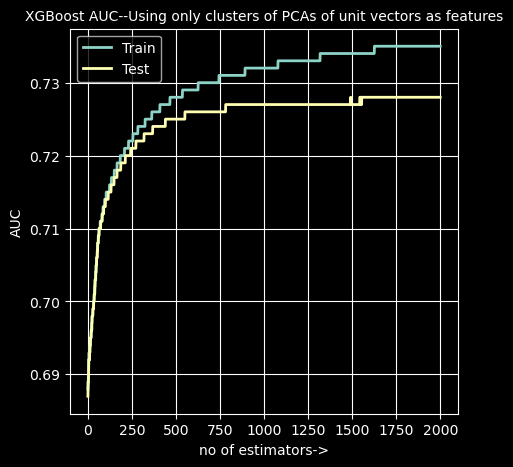

In [150]:

# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);

## Averaged unit vectors per level per feature
Unit vectors can be used look at clusters of features in Embedding Projector

In [151]:


# 26.0
train_trans['target'] = y_train

vec_trx , _ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = unitvecfolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for bannerpos
Checked for siteid
Checked for sitedomain
Checked for sitecategory
Checked for appid
Checked for appdomain
Checked for appcategory
Checked for devicemodel
Checked for devicetype
Checked for deviceconntype
Checked for Cfourteen
Checked for Cfifteen
Checked for Csixteen
Checked for Cseventeen
Checked for Ceighteen
Checked for Cnineteen
Checked for Ctwenty
Checked for Ctwentyone
For these columns we do not have vectors:  ['Cone', 'bannerpos', 'devicetype', 'deviceconntype', 'Cfifteen', 'Csixteen', 'Ceighteen']
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'D:\avazu\allmodels\unitvecfolder'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [ ]:
############# Done ###############